# Constants

In [2]:
DATASET_PATH = '../data/breast_cancer.csv'

# Imports

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Boosting algorithm
import lightgbm as lgb

# Add path to local project source code
import sys
sys.path.append('../src')

# Import custom classes
from RepeatedNestedCV import RepeatedNestedCV
from ModelTuner import ModelTuner

# Algorithms & Params

In [4]:
# We use lambda **kwargs so that Optuna can pass hyperparameters into the constructor.
estimators = {
    "LR": lambda **kwargs: LogisticRegression(random_state=42, **kwargs),
    "GNB": GaussianNB,
    "LDA": LinearDiscriminantAnalysis,
    "SVC": lambda **kwargs: SVC(random_state=42, probability=True, **kwargs), # Without the "probability" fixed value, AUC will be none for SVM
    "RF": lambda **kwargs: RandomForestClassifier(random_state=42, **kwargs),
    "LGBM": lambda **kwargs: lgb.LGBMClassifier(random_state=42, verbosity=-1, **kwargs), # Suppress warnings here, lgb sends warnings outside python warnings module
}

param_spaces = {
    "LR": lambda trial: {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'solver': 'saga', # Fixed for Elastic Net Regularization
        'penalty': 'elasticnet', # Fixed for Elastic Net Regularization
        'max_iter': 1000
    },
    "GNB": lambda trial: {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    },
    "LDA": lambda trial: {
        'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    },
    "SVC": lambda trial: {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e0, log=True),
    },
    "RF": lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    },
    "LGBM": lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30)
    }
}

# Analysis

## Prepare Dataset

In [6]:
df = pd.read_csv(DATASET_PATH)
df.drop('id', axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].replace({'M': '1', 'B': '0'}).astype(int)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.29140,0.16090,0.3029,0.08216
1,0,11.50,18.45,73.28,407.4,0.09345,0.05991,0.02638,0.02069,0.1834,...,12.97,22.46,83.12,508.9,0.1183,0.1049,0.08105,0.06544,0.2740,NaN
2,1,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.23220,0.11190,0.2809,0.06287
3,1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,...,22.66,30.93,145.30,1603.0,0.1390,0.3463,0.39120,0.17080,0.3007,0.08314
4,0,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,...,13.74,19.93,88.81,585.4,0.1483,NaN,0.22410,0.10560,0.3380,0.09584


## nCV

In [7]:
# Extract X and y from dataframe
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

In [6]:
rncv = RepeatedNestedCV(
    X=X,
    y=y,
    estimators=estimators,
    param_spaces=param_spaces,
)

rncv.run()

[I 2025-05-09 12:08:22,118] A new study created in memory with name: no-name-b0c4bc02-3c64-41ed-8cf6-0246fc267701
[I 2025-05-09 12:08:22,151] Trial 0 finished with value: 0.8702859020958894 and parameters: {'C': 0.017670169402947963, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8702859020958894.
[I 2025-05-09 12:08:22,237] Trial 1 finished with value: 0.9393040981882704 and parameters: {'C': 2.4658329458549115, 'l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-05-09 12:08:22,249] Trial 2 finished with value: 0.41353986515276836 and parameters: {'C': 0.0008632008168602552, 'l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-05-09 12:08:22,260] Trial 3 finished with value: 0.0 and parameters: {'C': 0.00022310108018679258, 'l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-05-09 12:08:22,288] Trial 4 finished with value: 0.9462551697346605 and parameters: {'


>>> Repetition 1/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:08:22,381] Trial 6 finished with value: 0.9372251342781337 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-05-09 12:08:22,393] Trial 7 finished with value: 0.6274179037336932 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-05-09 12:08:22,404] Trial 8 finished with value: 0.8609214171398861 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-05-09 12:08:22,417] Trial 9 finished with value: 0.923611111111111 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-05-09 12:08:22,452] Trial 10 finished with value: 0.9462585034013605 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 10 with value: 0.94625850340136

Tuning: GNB


[I 2025-05-09 12:08:24,234] Trial 18 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-05-09 12:08:24,247] Trial 19 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-05-09 12:08:24,261] Trial 20 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-05-09 12:08:24,273] Trial 21 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-05-09 12:08:24,285] Trial 22 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-05-09 12:08:24,297] Trial 23 finished with value: 0.8844444444444445 and par

Tuning: LDA


[I 2025-05-09 12:08:24,803] Trial 19 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,814] Trial 20 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,825] Trial 21 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,835] Trial 22 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,847] Trial 23 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,857] Trial 24 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-05-09 12:08:24,867] Trial 

Tuning: SVC


[I 2025-05-09 12:08:25,342] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-05-09 12:08:25,370] Trial 8 finished with value: 0.8219753375093838 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-05-09 12:08:25,398] Trial 9 finished with value: 0.7061208833360731 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-05-09 12:08:25,417] Trial 10 finished with value: 0.9381954163909052 and parameters: {'C': 77.62120319752464, 'gamma': 0.00010567900894501651}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-05-09 12:08:25,441] Trial 11 finished with value: 0.9403646130414508 and parameters: {'C': 2.544767558218772, 'gamma': 0.07631550861559508}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-05-09 12:

Tuning: RF


[I 2025-05-09 12:08:26,466] Trial 0 finished with value: 0.8947695919472994 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8947695919472994.
[I 2025-05-09 12:08:26,600] Trial 1 finished with value: 0.8901510248112189 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8947695919472994.
[I 2025-05-09 12:08:26,855] Trial 2 finished with value: 0.9019895579301519 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9019895579301519.
[I 2025-05-09 12:08:27,176] Trial 3 finished with value: 0.9103047962021038 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9103047962021038.
[I 2025-05-09 12:08:27,356] Trial 4 finished with value: 0.9203247115618249 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:08:38,437] Trial 0 finished with value: 0.9205228758169935 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9205228758169935.
[I 2025-05-09 12:08:38,677] Trial 1 finished with value: 0.8990727644192992 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9205228758169935.
[I 2025-05-09 12:08:38,955] Trial 2 finished with value: 0.9236878589819767 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9236878589819767.
[I 2025-05-09 12:08:39,359] Trial 3 finished with value: 0.9240129449838187 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:09:01,603] Trial 6 finished with value: 0.9490982539462145 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.963330689928628.
[I 2025-05-09 12:09:01,614] Trial 7 finished with value: 0.6422222222222222 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.963330689928628.
[I 2025-05-09 12:09:01,624] Trial 8 finished with value: 0.8600522685765677 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.963330689928628.
[I 2025-05-09 12:09:01,636] Trial 9 finished with value: 0.941968196213193 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.963330689928628.
[I 2025-05-09 12:09:01,669] Trial 10 finished with value: 0.970204081632653 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 10 with value: 0.970204081632653.
[I

Tuning: GNB


[I 2025-05-09 12:09:03,585] Trial 19 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-05-09 12:09:03,596] Trial 20 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-05-09 12:09:03,606] Trial 21 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-05-09 12:09:03,617] Trial 22 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-05-09 12:09:03,632] Trial 23 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-05-09 12:09:03,645] Trial 24 finished with value: 0.8511275491108968 and par

Tuning: LDA


[I 2025-05-09 12:09:04,147] Trial 17 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,157] Trial 18 finished with value: 0.9405310511301295 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,169] Trial 19 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,180] Trial 20 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,192] Trial 21 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,203] Trial 22 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-05-09 12:09:04,214] Trial 2

Tuning: SVC


[I 2025-05-09 12:09:04,755] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-05-09 12:09:04,787] Trial 8 finished with value: 0.8045404208194906 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-05-09 12:09:04,817] Trial 9 finished with value: 0.703343070431678 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-05-09 12:09:04,836] Trial 10 finished with value: 0.9488845343071762 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-05-09 12:09:04,879] Trial 11 finished with value: 0.8538361139484735 and parameters: {'C': 3.7808751628406823, 'gamma': 0.00011154569588957049}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-05-09 12:0

Tuning: RF


[I 2025-05-09 12:09:06,053] Trial 0 finished with value: 0.9345935545935545 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-05-09 12:09:06,190] Trial 1 finished with value: 0.9248072562358276 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-05-09 12:09:06,444] Trial 2 finished with value: 0.9210243822614957 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-05-09 12:09:06,769] Trial 3 finished with value: 0.9243435692033822 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-05-09 12:09:06,949] Trial 4 finished with value: 0.9383571746455591 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:09:20,797] Trial 0 finished with value: 0.9242579642579644 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-05-09 12:09:20,999] Trial 1 finished with value: 0.9114842430206312 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-05-09 12:09:21,189] Trial 2 finished with value: 0.9203296703296703 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-05-09 12:09:21,562] Trial 3 finished with value: 0.9346507223676784 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:09:44,334] Trial 6 finished with value: 0.9600560016374136 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-05-09 12:09:44,347] Trial 7 finished with value: 0.6072378716744914 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-05-09 12:09:44,359] Trial 8 finished with value: 0.8437339989759344 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-05-09 12:09:44,373] Trial 9 finished with value: 0.9215301955727488 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-05-09 12:09:44,408] Trial 10 finished with value: 0.9634963496349634 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 4 with value: 0.96699081672873

Tuning: GNB


[I 2025-05-09 12:09:46,476] Trial 18 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-05-09 12:09:46,487] Trial 19 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-05-09 12:09:46,499] Trial 20 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-05-09 12:09:46,511] Trial 21 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-05-09 12:09:46,523] Trial 22 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-05-09 12:09:46,534] Trial 23 finished with value: 0.8638262322472849 and par

Tuning: LDA


[I 2025-05-09 12:09:47,053] Trial 18 finished with value: 0.9368075920495276 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,064] Trial 19 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,075] Trial 20 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,087] Trial 21 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,098] Trial 22 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,108] Trial 23 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-05-09 12:09:47,119] Trial 2

Tuning: SVC


[I 2025-05-09 12:09:47,624] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-05-09 12:09:47,656] Trial 8 finished with value: 0.7764079574110395 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-05-09 12:09:47,685] Trial 9 finished with value: 0.6861111111111112 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-05-09 12:09:47,705] Trial 10 finished with value: 0.9669908167287318 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 10 with value: 0.9669908167287318.
[I 2025-05-09 12:09:47,725] Trial 11 finished with value: 0.9639449381831388 and parameters: {'C': 70.41830285016022, 'gamma': 0.010971335142140359}. Best is trial 10 with value: 0.9669908167287318.
[I 2025-05-09 12:0

Tuning: RF


[I 2025-05-09 12:09:48,928] Trial 1 finished with value: 0.9052029208811897 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9094640892660695.
[I 2025-05-09 12:09:49,185] Trial 2 finished with value: 0.8989462451647325 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9094640892660695.
[I 2025-05-09 12:09:49,506] Trial 3 finished with value: 0.9227414236134707 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9227414236134707.
[I 2025-05-09 12:09:49,687] Trial 4 finished with value: 0.9094640892660695 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9227414236134707.
[I 2025-05-09 12:09:49,945] Trial 5 finished with value: 0.9119985389433762 and parameters: {'n_

Tuning: LGBM


[I 2025-05-09 12:10:04,326] Trial 0 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-05-09 12:10:04,530] Trial 1 finished with value: 0.8838917989153202 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-05-09 12:10:04,733] Trial 2 finished with value: 0.9294929492949295 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-05-09 12:10:05,126] Trial 3 finished with value: 0.933061972863953 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is trial


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:10:22,093] Trial 6 finished with value: 0.9497568532363441 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.963613924534215.
[I 2025-05-09 12:10:22,105] Trial 7 finished with value: 0.6748483583926621 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.963613924534215.
[I 2025-05-09 12:10:22,117] Trial 8 finished with value: 0.8472928352627601 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.963613924534215.
[I 2025-05-09 12:10:22,131] Trial 9 finished with value: 0.9346222699606158 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.963613924534215.
[I 2025-05-09 12:10:22,168] Trial 10 finished with value: 0.9603843498760689 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 4 with value: 0.963613924534215.
[

Tuning: GNB


[I 2025-05-09 12:10:23,951] Trial 17 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.1272048050586266e-09}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-05-09 12:10:23,964] Trial 18 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-05-09 12:10:23,977] Trial 19 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-05-09 12:10:23,987] Trial 20 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-05-09 12:10:23,999] Trial 21 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-05-09 12:10:24,011] Trial 22 finished with value: 0.8817331791016002 and pa

Tuning: LDA


[I 2025-05-09 12:10:24,569] Trial 16 finished with value: 0.9295750897982282 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,581] Trial 17 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,593] Trial 18 finished with value: 0.9295750897982282 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,605] Trial 19 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,615] Trial 20 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,627] Trial 21 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-05-09 12:10:24,639] Trial 22

Tuning: SVC


[I 2025-05-09 12:10:25,159] Trial 6 finished with value: 0.9455746893154847 and parameters: {'C': 14.528246637516036, 'gamma': 0.0007068974950624604}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-05-09 12:10:25,189] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-05-09 12:10:25,218] Trial 8 finished with value: 0.8224110256268334 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-05-09 12:10:25,247] Trial 9 finished with value: 0.7402286125279364 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-05-09 12:10:25,273] Trial 10 finished with value: 0.9507366272072154 and parameters: {'C': 1.4663473918669496, 'gamma': 0.07388629290069335}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-05-09 12:

Tuning: RF


[I 2025-05-09 12:10:26,333] Trial 0 finished with value: 0.9026738297798994 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9026738297798994.
[I 2025-05-09 12:10:26,470] Trial 1 finished with value: 0.9015401540154016 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9026738297798994.
[I 2025-05-09 12:10:26,732] Trial 2 finished with value: 0.8956348465035182 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9026738297798994.
[I 2025-05-09 12:10:27,064] Trial 3 finished with value: 0.9118724702658945 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9118724702658945.
[I 2025-05-09 12:10:27,254] Trial 4 finished with value: 0.9063766031403572 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:10:41,169] Trial 0 finished with value: 0.9255319538613129 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9255319538613129.
[I 2025-05-09 12:10:41,371] Trial 1 finished with value: 0.902654832159401 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9255319538613129.
[I 2025-05-09 12:10:41,577] Trial 2 finished with value: 0.9376649240726911 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9376649240726911.
[I 2025-05-09 12:10:41,980] Trial 3 finished with value: 0.9228237818388095 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is trial


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:10:58,239] Trial 7 finished with value: 0.62956411510445 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-05-09 12:10:58,251] Trial 8 finished with value: 0.8791265397536394 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-05-09 12:10:58,266] Trial 9 finished with value: 0.9483790939056034 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-05-09 12:10:58,347] Trial 10 finished with value: 0.9668646864686469 and parameters: {'C': 66.33628120542436, 'l1_ratio': 0.4733273214546686}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-05-09 12:10:58,387] Trial 11 finished with value: 0.9668646864686469 and parameters: {'C': 1.9638612713649035, 'l1_ratio': 0.011863204306079927}. Best is trial 1 with value: 0.96686468646864

Tuning: GNB


[I 2025-05-09 12:11:00,515] Trial 19 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-05-09 12:11:00,525] Trial 20 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.883935328517372.
[I 2025-05-09 12:11:00,536] Trial 21 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-05-09 12:11:00,547] Trial 22 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-05-09 12:11:00,558] Trial 23 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.883935328517372.
[I 2025-05-09 12:11:00,570] Trial 24 finished with value: 0.883935328517372 and parameters: {'

Tuning: LDA


[I 2025-05-09 12:11:01,056] Trial 18 finished with value: 0.941151202749141 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,066] Trial 19 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,076] Trial 20 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,086] Trial 21 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,096] Trial 22 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,107] Trial 23 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:11:01,117] Trial 24 finished w

Tuning: SVC


[I 2025-05-09 12:11:01,600] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-05-09 12:11:01,628] Trial 8 finished with value: 0.8450539881574365 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-05-09 12:11:01,656] Trial 9 finished with value: 0.7194874199093609 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-05-09 12:11:01,675] Trial 10 finished with value: 0.9601307189542484 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-05-09 12:11:01,694] Trial 11 finished with value: 0.9530600118835414 and parameters: {'C': 70.41830285016022, 'gamma': 0.010971335142140359}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-05-09 12:11:

Tuning: RF


[I 2025-05-09 12:11:02,856] Trial 1 finished with value: 0.9104139433551198 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-05-09 12:11:03,111] Trial 2 finished with value: 0.9141176470588235 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-05-09 12:11:03,436] Trial 3 finished with value: 0.9216923976806589 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-05-09 12:11:03,615] Trial 4 finished with value: 0.9215536938309216 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-05-09 12:11:03,876] Trial 5 finished with value: 0.9205155809698616 and parameters: {'n_

Tuning: LGBM


[I 2025-05-09 12:11:14,678] Trial 0 finished with value: 0.9399881164587046 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9399881164587046.
[I 2025-05-09 12:11:14,876] Trial 1 finished with value: 0.9104179045355516 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9399881164587046.
[I 2025-05-09 12:11:15,078] Trial 2 finished with value: 0.9466633329999666 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9466633329999666.
[I 2025-05-09 12:11:15,462] Trial 3 finished with value: 0.9500257476728065 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


>>> Repetition 2/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:11:30,356] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-05-09 12:11:30,396] Trial 10 finished with value: 0.9665954038769572 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-05-09 12:11:30,440] Trial 11 finished with value: 0.9665954038769572 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-05-09 12:11:30,475] Trial 12 finished with value: 0.9665954038769572 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-05-09 12:11:30,563] Trial 13 finished with value: 0.9537018690971535 and parameters: {'C': 91.63812627651475, 'l1_ratio': 0.4329730998746223}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-05-09 

Tuning: GNB


[I 2025-05-09 12:11:32,043] Trial 19 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-05-09 12:11:32,055] Trial 20 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-05-09 12:11:32,065] Trial 21 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-05-09 12:11:32,075] Trial 22 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-05-09 12:11:32,086] Trial 23 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-05-09 12:11:32,097] Trial 24 finished with value: 0.8845188124125505 and 

Tuning: LDA


[I 2025-05-09 12:11:32,577] Trial 19 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,589] Trial 20 finished with value: 0.9331614012465076 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,599] Trial 21 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,609] Trial 22 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,619] Trial 23 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,628] Trial 24 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-05-09 12:11:32,640] Trial 25 f

Tuning: SVC


[I 2025-05-09 12:11:33,103] Trial 7 finished with value: 0.9594585308871023 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-05-09 12:11:33,132] Trial 8 finished with value: 0.6724386724386724 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-05-09 12:11:33,163] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-05-09 12:11:33,182] Trial 10 finished with value: 0.9659120972059334 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-05-09 12:11:33,202] Trial 11 finished with value: 0.9694165292817942 and parameters: {'C': 2.7085071145534783, 'gamma': 0.00791485028356628}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-05-09 12:11:33,

Tuning: RF


[I 2025-05-09 12:11:34,360] Trial 1 finished with value: 0.9044130472701902 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9092970521541951.
[I 2025-05-09 12:11:34,466] Trial 2 finished with value: 0.9111752445085779 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9111752445085779.
[I 2025-05-09 12:11:34,623] Trial 3 finished with value: 0.9147835563300832 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9147835563300832.
[I 2025-05-09 12:11:34,826] Trial 4 finished with value: 0.9106509620528311 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9147835563300832.
[I 2025-05-09 12:11:35,145] Trial 5 finished with value: 0.9110926101980829 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:11:47,415] Trial 0 finished with value: 0.9318008189707859 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-05-09 12:11:47,669] Trial 1 finished with value: 0.9211155424497433 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-05-09 12:11:47,840] Trial 2 finished with value: 0.9306375738164349 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-05-09 12:11:47,986] Trial 3 finished with value: 0.9238446615154959 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:12:04,942] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.96006400640064.
[I 2025-05-09 12:12:04,982] Trial 10 finished with value: 0.9568956895689569 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.96006400640064.
[I 2025-05-09 12:12:05,069] Trial 11 finished with value: 0.957095709570957 and parameters: {'C': 58.75664834858915, 'l1_ratio': 0.4248924349322103}. Best is trial 3 with value: 0.96006400640064.
[I 2025-05-09 12:12:05,122] Trial 12 finished with value: 0.9603254443091368 and parameters: {'C': 2.261150882962334, 'l1_ratio': 0.009620009291182452}. Best is trial 12 with value: 0.9603254443091368.
[I 2025-05-09 12:12:05,153] Trial 13 finished with value: 0.9533973397339733 and parameters: {'C': 0.627982092142691, 'l1_ratio': 0.05416200206152455}. Best is trial 12 with value: 0.9603254443091368.
[I 2025-05-09 12:1

Tuning: GNB


[I 2025-05-09 12:12:07,836] Trial 20 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-05-09 12:12:07,846] Trial 21 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-05-09 12:12:07,857] Trial 22 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-05-09 12:12:07,869] Trial 23 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-05-09 12:12:07,879] Trial 24 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-05-09 12:12:07,891] Trial 25 finished with value: 0.8583673469387755 and 

Tuning: LDA


[I 2025-05-09 12:12:08,372] Trial 20 finished with value: 0.934278350515464 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,381] Trial 21 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,391] Trial 22 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,402] Trial 23 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,413] Trial 24 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,422] Trial 25 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-05-09 12:12:08,432] Trial 26 finished with

Tuning: SVC


[I 2025-05-09 12:12:08,892] Trial 7 finished with value: 0.9523809523809524 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-05-09 12:12:08,921] Trial 8 finished with value: 0.6671250678700811 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-05-09 12:12:08,951] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-05-09 12:12:08,972] Trial 10 finished with value: 0.9415763728171681 and parameters: {'C': 85.64663445407959, 'gamma': 0.00010521677845624421}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-05-09 12:12:08,991] Trial 11 finished with value: 0.952996632996633 and parameters: {'C': 5.934336536959914, 'gamma': 0.005006909478572041}. Best is trial 11 with value: 0.952996632996633.
[I 2025-05-09 12:12:09,

Tuning: RF


[I 2025-05-09 12:12:10,220] Trial 1 finished with value: 0.9208738880167452 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-05-09 12:12:10,331] Trial 2 finished with value: 0.9114225708285114 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-05-09 12:12:10,495] Trial 3 finished with value: 0.9097257597196955 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-05-09 12:12:10,698] Trial 4 finished with value: 0.9086628362036638 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-05-09 12:12:11,023] Trial 5 finished with value: 0.9049170954831333 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:12:19,127] Trial 0 finished with value: 0.9472686044114615 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-05-09 12:12:19,382] Trial 1 finished with value: 0.9435643564356435 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-05-09 12:12:19,555] Trial 2 finished with value: 0.9347550139629348 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-05-09 12:12:19,692] Trial 3 finished with value: 0.9410388029094171 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:12:34,471] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 7 with value: 0.957350085665334.
[I 2025-05-09 12:12:34,557] Trial 10 finished with value: 0.957350085665334 and parameters: {'C': 83.03331215920704, 'l1_ratio': 0.005521250092107244}. Best is trial 7 with value: 0.957350085665334.
[I 2025-05-09 12:12:34,643] Trial 11 finished with value: 0.957350085665334 and parameters: {'C': 76.98123919677761, 'l1_ratio': 0.014268393733033763}. Best is trial 7 with value: 0.957350085665334.
[I 2025-05-09 12:12:34,729] Trial 12 finished with value: 0.957350085665334 and parameters: {'C': 57.50579077018148, 'l1_ratio': 0.2207284664975004}. Best is trial 7 with value: 0.957350085665334.
[I 2025-05-09 12:12:34,798] Trial 13 finished with value: 0.9539248042451304 and parameters: {'C': 3.634395348645825, 'l1_ratio': 0.3374537693902746}. Best is trial 7 with value: 0.957350085665334.
[I 2025-05-09 12:12:3

Tuning: GNB


[I 2025-05-09 12:12:36,990] Trial 20 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-05-09 12:12:37,000] Trial 21 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-05-09 12:12:37,012] Trial 22 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-05-09 12:12:37,022] Trial 23 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-05-09 12:12:37,033] Trial 24 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-05-09 12:12:37,044] Trial 25 finished with value: 0.8935023303757417 and 

Tuning: LDA


[I 2025-05-09 12:12:37,524] Trial 19 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,534] Trial 20 finished with value: 0.9302479857191103 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,545] Trial 21 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,555] Trial 22 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,565] Trial 23 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,576] Trial 24 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-05-09 12:12:37,585] Trial 25 f

Tuning: SVC


[I 2025-05-09 12:12:38,062] Trial 7 finished with value: 0.9628241599670172 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-05-09 12:12:38,090] Trial 8 finished with value: 0.6913200509691738 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-05-09 12:12:38,121] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-05-09 12:12:38,139] Trial 10 finished with value: 0.9729251700680273 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 10 with value: 0.9729251700680273.
[I 2025-05-09 12:12:38,159] Trial 11 finished with value: 0.9729251700680273 and parameters: {'C': 2.7085071145534783, 'gamma': 0.00791485028356628}. Best is trial 10 with value: 0.9729251700680273.
[I 2025-05-09 12:12:3

Tuning: RF


[I 2025-05-09 12:12:39,345] Trial 1 finished with value: 0.9076952567051576 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-05-09 12:12:39,450] Trial 2 finished with value: 0.9019211725094078 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-05-09 12:12:39,610] Trial 3 finished with value: 0.9037995337995337 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-05-09 12:12:39,813] Trial 4 finished with value: 0.9112642802741813 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-05-09 12:12:40,133] Trial 5 finished with value: 0.9047038037137046 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:12:53,311] Trial 0 finished with value: 0.9445396281489943 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9445396281489943.
[I 2025-05-09 12:12:53,564] Trial 1 finished with value: 0.9510755758614126 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 1 with value: 0.9510755758614126.
[I 2025-05-09 12:12:53,730] Trial 2 finished with value: 0.9444046214576209 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 1 with value: 0.9510755758614126.
[I 2025-05-09 12:12:53,864] Trial 3 finished with value: 0.9510755758614126 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:13:15,132] Trial 8 finished with value: 0.9139839823689718 and parameters: {'C': 0.026911424589281197, 'l1_ratio': 0.3160964710182087}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-05-09 12:13:15,142] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-05-09 12:13:15,184] Trial 10 finished with value: 0.9468626862686268 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-05-09 12:13:15,231] Trial 11 finished with value: 0.9471287128712871 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 11 with value: 0.9471287128712871.
[I 2025-05-09 12:13:15,270] Trial 12 finished with value: 0.9468626862686268 and parameters: {'C': 0.8313245970979775, 'l1_ratio': 0.5002415936228346}. Best is trial 11 with value: 0.9471287128712871.
[I 2025-05

Tuning: GNB


[I 2025-05-09 12:13:16,576] Trial 20 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-05-09 12:13:16,588] Trial 21 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-05-09 12:13:16,599] Trial 22 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-05-09 12:13:16,609] Trial 23 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-05-09 12:13:16,620] Trial 24 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 1.0068655798241915e-10}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-05-09 12:13:16,631] Trial 25 finished with value: 0.8627845273006564 and 

Tuning: LDA


[I 2025-05-09 12:13:17,111] Trial 19 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,121] Trial 20 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,132] Trial 21 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,142] Trial 22 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,152] Trial 23 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,162] Trial 24 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:13:17,172] Trial 25 f

Tuning: SVC


[I 2025-05-09 12:13:17,636] Trial 6 finished with value: 0.0 and parameters: {'C': 0.018711371838538108, 'gamma': 0.0001688650397596817}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-05-09 12:13:17,653] Trial 7 finished with value: 0.955885384456813 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-05-09 12:13:17,682] Trial 8 finished with value: 0.6913648558014756 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-05-09 12:13:17,713] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-05-09 12:13:17,733] Trial 10 finished with value: 0.9591114171379266 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 10 with value: 0.9591114171379266.
[I 2025-05-09 12:13:17,752] Trial 1

Tuning: RF


[I 2025-05-09 12:13:18,945] Trial 1 finished with value: 0.9164652540020356 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-05-09 12:13:19,051] Trial 2 finished with value: 0.9075904532349259 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-05-09 12:13:19,213] Trial 3 finished with value: 0.9071804484175617 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-05-09 12:13:19,419] Trial 4 finished with value: 0.9070871531597603 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-05-09 12:13:19,741] Trial 5 finished with value: 0.909798587335369 and parameters: {'n_es

Tuning: LGBM


[I 2025-05-09 12:13:33,644] Trial 0 finished with value: 0.9352036025111099 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9352036025111099.
[I 2025-05-09 12:13:33,910] Trial 1 finished with value: 0.9376820034944672 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 1 with value: 0.9376820034944672.
[I 2025-05-09 12:13:34,081] Trial 2 finished with value: 0.9282151835093012 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 1 with value: 0.9376820034944672.
[I 2025-05-09 12:13:34,217] Trial 3 finished with value: 0.9377384351798973 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:13:51,940] Trial 10 finished with value: 0.9551942678623306 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-05-09 12:13:51,977] Trial 11 finished with value: 0.9551942678623306 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-05-09 12:13:52,008] Trial 12 finished with value: 0.9551942678623306 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-05-09 12:13:52,079] Trial 13 finished with value: 0.9424971444888636 and parameters: {'C': 91.63812627651475, 'l1_ratio': 0.4329730998746223}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-05-09 12:13:52,108] Trial 14 finished with value: 0.9551942678623306 and parameters: {'C': 0.6229329456279659, 'l1_ratio': 0.650380546553906}. Best is trial 3 with value: 0.9551942678623306.
[I

Tuning: GNB


[I 2025-05-09 12:13:53,714] Trial 19 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-05-09 12:13:53,725] Trial 20 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-05-09 12:13:53,736] Trial 21 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-05-09 12:13:53,746] Trial 22 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-05-09 12:13:53,758] Trial 23 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-05-09 12:13:53,769] Trial 24 finished with value: 0.8681537796636807 and 

Tuning: LDA


[I 2025-05-09 12:13:54,262] Trial 19 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,272] Trial 20 finished with value: 0.9141560347965262 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,283] Trial 21 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,294] Trial 22 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,306] Trial 23 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,318] Trial 24 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-05-09 12:13:54,329] Trial 25 f

Tuning: SVC


[I 2025-05-09 12:13:54,798] Trial 7 finished with value: 0.9442402519821874 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-05-09 12:13:54,827] Trial 8 finished with value: 0.6975441225441225 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-05-09 12:13:54,857] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-05-09 12:13:54,876] Trial 10 finished with value: 0.9449645390070921 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-05-09 12:13:54,896] Trial 11 finished with value: 0.9378409453848611 and parameters: {'C': 2.7085071145534783, 'gamma': 0.00791485028356628}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-05-09 12:13:54,

Tuning: RF


[I 2025-05-09 12:13:56,166] Trial 1 finished with value: 0.8968358944433638 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-05-09 12:13:56,272] Trial 2 finished with value: 0.9028663892741563 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-05-09 12:13:56,431] Trial 3 finished with value: 0.8954448329448329 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-05-09 12:13:56,636] Trial 4 finished with value: 0.8835785493129578 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-05-09 12:13:56,958] Trial 5 finished with value: 0.8870159699099766 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:14:05,113] Trial 0 finished with value: 0.9337894573771103 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9337894573771103.
[I 2025-05-09 12:14:05,381] Trial 1 finished with value: 0.9333033063090115 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9337894573771103.
[I 2025-05-09 12:14:05,552] Trial 2 finished with value: 0.943160234390786 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 2 with value: 0.943160234390786.
[I 2025-05-09 12:14:05,687] Trial 3 finished with value: 0.9159927436376241 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is trial


>>> Repetition 3/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:14:29,100] Trial 5 finished with value: 0.9602614379084967 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-05-09 12:14:29,113] Trial 6 finished with value: 0.923016961788813 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-05-09 12:14:29,122] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-05-09 12:14:29,207] Trial 8 finished with value: 0.9602614379084967 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-05-09 12:14:29,235] Trial 9 finished with value: 0.9567597544068133 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-05-09 12:14

Tuning: GNB


[I 2025-05-09 12:14:31,935] Trial 20 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-05-09 12:14:31,946] Trial 21 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-05-09 12:14:31,957] Trial 22 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-05-09 12:14:31,968] Trial 23 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-05-09 12:14:31,979] Trial 24 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-05-09 12:14:31,989] Trial 25 finished with value: 0.8537335680192824 and pa

Tuning: LDA


[I 2025-05-09 12:14:32,462] Trial 19 finished with value: 0.9374231325737022 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,472] Trial 20 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,482] Trial 21 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,492] Trial 22 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,502] Trial 23 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,512] Trial 24 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:14:32,523] T

Tuning: SVC


[I 2025-05-09 12:14:33,012] Trial 8 finished with value: 0.896070135440758 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.95999799979998.
[I 2025-05-09 12:14:33,034] Trial 9 finished with value: 0.9059045463120166 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.95999799979998.
[I 2025-05-09 12:14:33,067] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.95999799979998.
[I 2025-05-09 12:14:33,087] Trial 11 finished with value: 0.941778350515464 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.95999799979998.
[I 2025-05-09 12:14:33,106] Trial 12 finished with value: 0.9663925576231093 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 12 with value: 0.9663925576231093.
[I 2025-05-09 12:14:33,125] Tria

Tuning: RF


[I 2025-05-09 12:14:34,227] Trial 0 finished with value: 0.8860992958931103 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-05-09 12:14:34,424] Trial 1 finished with value: 0.8783414729613123 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-05-09 12:14:34,663] Trial 2 finished with value: 0.885004690945285 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-05-09 12:14:34,868] Trial 3 finished with value: 0.8772293429637514 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-05-09 12:14:35,223] Trial 4 finished with value: 0.8850793650793651 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:14:46,928] Trial 0 finished with value: 0.9234923492349235 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9234923492349235.
[I 2025-05-09 12:14:47,358] Trial 1 finished with value: 0.9397858153162254 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9397858153162254.
[I 2025-05-09 12:14:47,752] Trial 2 finished with value: 0.9361514110594733 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 1 with value: 0.9397858153162254.
[I 2025-05-09 12:14:48,152] Trial 3 finished with value: 0.9263945578231292 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:15:08,454] Trial 5 finished with value: 0.9631649831649831 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-05-09 12:15:08,469] Trial 6 finished with value: 0.9383503401360543 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-05-09 12:15:08,478] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-05-09 12:15:08,560] Trial 8 finished with value: 0.9631649831649831 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-05-09 12:15:08,591] Trial 9 finished with value: 0.9628241599670172 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-05-09 12:1

Tuning: GNB


[I 2025-05-09 12:15:10,458] Trial 18 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 2.1769308940621743e-09}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-05-09 12:15:10,470] Trial 19 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-05-09 12:15:10,481] Trial 20 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-05-09 12:15:10,492] Trial 21 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-05-09 12:15:10,503] Trial 22 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-05-09 12:15:10,514] Trial 23 finished with value: 0.8757324433870827 and par

Tuning: LDA


[I 2025-05-09 12:15:11,025] Trial 17 finished with value: 0.9334643599881162 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,036] Trial 18 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,048] Trial 19 finished with value: 0.9334643599881162 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,060] Trial 20 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,071] Trial 21 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,082] Trial 22 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-05-09 12:15:11,094] Tri

Tuning: SVC


[I 2025-05-09 12:15:11,591] Trial 6 finished with value: 0.0 and parameters: {'C': 0.13748572409646073, 'gamma': 0.00028435102918234324}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-05-09 12:15:11,628] Trial 7 finished with value: 0.0 and parameters: {'C': 0.012288371905419274, 'gamma': 0.6759090731231361}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-05-09 12:15:11,666] Trial 8 finished with value: 0.9015945940650578 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-05-09 12:15:11,691] Trial 9 finished with value: 0.9223471986417656 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-05-09 12:15:11,725] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-05-09 12:15:11,745] Trial 11 finished with

Tuning: RF


[I 2025-05-09 12:15:13,008] Trial 0 finished with value: 0.9194612794612794 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9194612794612794.
[I 2025-05-09 12:15:13,238] Trial 1 finished with value: 0.9302970297029702 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-05-09 12:15:13,505] Trial 2 finished with value: 0.928163633039489 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-05-09 12:15:13,740] Trial 3 finished with value: 0.9030903090309031 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-05-09 12:15:14,158] Trial 4 finished with value: 0.9271848753502802 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:15:25,537] Trial 0 finished with value: 0.9340497933288475 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9340497933288475.
[I 2025-05-09 12:15:25,978] Trial 1 finished with value: 0.9337208230626984 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 0 with value: 0.9340497933288475.
[I 2025-05-09 12:15:26,390] Trial 2 finished with value: 0.9407234841131172 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.9407234841131172.
[I 2025-05-09 12:15:26,815] Trial 3 finished with value: 0.9407234841131172 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:15:42,863] Trial 5 finished with value: 0.9384859584859585 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-05-09 12:15:42,878] Trial 6 finished with value: 0.9418316831683168 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-05-09 12:15:42,888] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-05-09 12:15:42,975] Trial 8 finished with value: 0.9384859584859585 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-05-09 12:15:43,008] Trial 9 finished with value: 0.9632081414527199 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 9 with value: 0.9632081414527199.
[I 2025-05-09 12:1

Tuning: GNB


[I 2025-05-09 12:15:44,635] Trial 19 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-05-09 12:15:44,645] Trial 20 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-05-09 12:15:44,657] Trial 21 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-05-09 12:15:44,668] Trial 22 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-05-09 12:15:44,680] Trial 23 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-05-09 12:15:44,691] Trial 24 finished with value: 0.8482245131729668 and par

Tuning: LDA


[I 2025-05-09 12:15:45,183] Trial 17 finished with value: 0.9374231325737022 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,199] Trial 18 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,210] Trial 19 finished with value: 0.9374231325737022 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,222] Trial 20 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,233] Trial 21 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,244] Trial 22 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-05-09 12:15:45,255] Tri

Tuning: SVC


[I 2025-05-09 12:15:45,773] Trial 8 finished with value: 0.8637245082927109 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.966797385620915.
[I 2025-05-09 12:15:45,795] Trial 9 finished with value: 0.9300438596491228 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.966797385620915.
[I 2025-05-09 12:15:45,828] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.966797385620915.
[I 2025-05-09 12:15:45,847] Trial 11 finished with value: 0.9520302966547444 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.966797385620915.
[I 2025-05-09 12:15:45,865] Trial 12 finished with value: 0.9666666666666667 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 5 with value: 0.966797385620915.
[I 2025-05-09 12:15:45,885] 

Tuning: RF


[I 2025-05-09 12:15:47,162] Trial 0 finished with value: 0.9007649308620183 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9007649308620183.
[I 2025-05-09 12:15:47,363] Trial 1 finished with value: 0.8910679611650485 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9007649308620183.
[I 2025-05-09 12:15:47,612] Trial 2 finished with value: 0.9013649908680188 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9013649908680188.
[I 2025-05-09 12:15:47,820] Trial 3 finished with value: 0.8829309501578408 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9013649908680188.
[I 2025-05-09 12:15:48,185] Trial 4 finished with value: 0.9115790809850216 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:16:02,330] Trial 0 finished with value: 0.92718954248366 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.92718954248366.
[I 2025-05-09 12:16:02,742] Trial 1 finished with value: 0.9297272306981045 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9297272306981045.
[I 2025-05-09 12:16:03,159] Trial 2 finished with value: 0.9230256358969231 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 1 with value: 0.9297272306981045.
[I 2025-05-09 12:16:03,579] Trial 3 finished with value: 0.9267181620122796 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is trial


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:16:26,181] Trial 5 finished with value: 0.9635571400277283 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-05-09 12:16:26,194] Trial 6 finished with value: 0.9477824084228997 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-05-09 12:16:26,205] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-05-09 12:16:26,288] Trial 8 finished with value: 0.9667280453535549 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 8 with value: 0.9667280453535549.
[I 2025-05-09 12:16:26,321] Trial 9 finished with value: 0.9595080793707025 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 8 with value: 0.9667280453535549.
[I 2025-05-09 12:1

Tuning: GNB


[I 2025-05-09 12:16:28,631] Trial 19 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-05-09 12:16:28,642] Trial 20 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-05-09 12:16:28,654] Trial 21 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-05-09 12:16:28,664] Trial 22 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-05-09 12:16:28,676] Trial 23 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-05-09 12:16:28,686] Trial 24 finished with value: 0.8765839136591996 and par

Tuning: LDA


[I 2025-05-09 12:16:29,176] Trial 19 finished with value: 0.9328337725076855 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,187] Trial 20 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,196] Trial 21 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,208] Trial 22 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,218] Trial 23 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,229] Trial 24 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-05-09 12:16:29,239] T

Tuning: SVC


[I 2025-05-09 12:16:29,730] Trial 8 finished with value: 0.9037511870845204 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-05-09 12:16:29,752] Trial 9 finished with value: 0.91384345301396 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-05-09 12:16:29,786] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-05-09 12:16:29,806] Trial 11 finished with value: 0.9590252767773776 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-05-09 12:16:29,825] Trial 12 finished with value: 0.9631548989232658 and parameters: {'C': 88.20504491022047, 'gamma': 0.0024642537727436256}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-05-09 12:16:29,8

Tuning: RF


[I 2025-05-09 12:16:30,986] Trial 0 finished with value: 0.8997709049255441 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8997709049255441.
[I 2025-05-09 12:16:31,182] Trial 1 finished with value: 0.9064081408140815 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-05-09 12:16:31,419] Trial 2 finished with value: 0.8970520616126413 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-05-09 12:16:31,626] Trial 3 finished with value: 0.8995257619108484 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-05-09 12:16:31,984] Trial 4 finished with value: 0.8999824645430444 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:16:42,642] Trial 0 finished with value: 0.9286707992890926 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-05-09 12:16:43,073] Trial 1 finished with value: 0.9218288537239205 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-05-09 12:16:43,495] Trial 2 finished with value: 0.9252975095080358 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-05-09 12:16:43,898] Trial 3 finished with value: 0.9320315162420426 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:17:05,205] Trial 5 finished with value: 0.9636290687892318 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-05-09 12:17:05,225] Trial 6 finished with value: 0.9372327621175548 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-05-09 12:17:05,239] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-05-09 12:17:05,333] Trial 8 finished with value: 0.9636290687892318 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-05-09 12:17:05,366] Trial 9 finished with value: 0.9630235932756941 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-05-09 12:1

Tuning: GNB


[I 2025-05-09 12:17:08,185] Trial 17 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 2.8660561607740846e-08}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-05-09 12:17:08,196] Trial 18 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 2.1769308940621743e-09}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-05-09 12:17:08,209] Trial 19 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-05-09 12:17:08,220] Trial 20 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-05-09 12:17:08,232] Trial 21 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-05-09 12:17:08,243] Trial 22 finished with value: 0.8630338733431516 and pa

Tuning: LDA


[I 2025-05-09 12:17:08,770] Trial 18 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,781] Trial 19 finished with value: 0.9450106737477872 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,791] Trial 20 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,801] Trial 21 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,812] Trial 22 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,823] Trial 23 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-05-09 12:17:08,833] T

Tuning: SVC


[I 2025-05-09 12:17:09,458] Trial 7 finished with value: 0.0 and parameters: {'C': 0.012288371905419274, 'gamma': 0.6759090731231361}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-05-09 12:17:09,497] Trial 8 finished with value: 0.9015397581769262 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-05-09 12:17:09,519] Trial 9 finished with value: 0.9293293404318249 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-05-09 12:17:09,554] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-05-09 12:17:09,575] Trial 11 finished with value: 0.9483637665592553 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-05-09 12:17:09,594] Trial 12 f

Tuning: RF


[I 2025-05-09 12:17:10,742] Trial 0 finished with value: 0.8974673202614379 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8974673202614379.
[I 2025-05-09 12:17:10,945] Trial 1 finished with value: 0.912742019884877 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.912742019884877.
[I 2025-05-09 12:17:11,187] Trial 2 finished with value: 0.9093190674327984 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.912742019884877.
[I 2025-05-09 12:17:11,396] Trial 3 finished with value: 0.8945320396199716 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.912742019884877.
[I 2025-05-09 12:17:11,780] Trial 4 finished with value: 0.9167402177110916 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:17:27,213] Trial 0 finished with value: 0.9293226898887276 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9293226898887276.
[I 2025-05-09 12:17:27,609] Trial 1 finished with value: 0.9352926931290315 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9352926931290315.
[I 2025-05-09 12:17:27,994] Trial 2 finished with value: 0.9382931882931883 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.9382931882931883.
[I 2025-05-09 12:17:28,389] Trial 3 finished with value: 0.9291491063130822 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


>>> Repetition 4/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:17:50,936] Trial 5 finished with value: 0.9535973597359736 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9535973597359736.
[I 2025-05-09 12:17:51,020] Trial 6 finished with value: 0.9535973597359736 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9535973597359736.
[I 2025-05-09 12:17:51,045] Trial 7 finished with value: 0.9552462772050401 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9552462772050401.
[I 2025-05-09 12:17:51,129] Trial 8 finished with value: 0.9535973597359736 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9552462772050401.
[I 2025-05-09 12:17:51,142] Trial 9 finished with value: 0.9408479532163744 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9552462772050401.
[I 2

Tuning: GNB


[I 2025-05-09 12:17:53,496] Trial 20 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-05-09 12:17:53,506] Trial 21 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-05-09 12:17:53,518] Trial 22 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-05-09 12:17:53,529] Trial 23 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-05-09 12:17:53,540] Trial 24 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-05-09 12:17:53,551] Trial 25 finished with value: 0.8840983903056611 and param

Tuning: LDA


[I 2025-05-09 12:17:54,029] Trial 19 finished with value: 0.9402476044181114 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,040] Trial 20 finished with value: 0.9402476044181114 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,050] Trial 21 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,060] Trial 22 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,070] Trial 23 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,081] Trial 24 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-05-09 12:17:54,092] Tria

Tuning: SVC


[I 2025-05-09 12:17:54,548] Trial 8 finished with value: 0.9162706204881567 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-05-09 12:17:54,577] Trial 9 finished with value: 0.74291742013261 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-05-09 12:17:54,618] Trial 10 finished with value: 0.21708182527854658 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-05-09 12:17:54,645] Trial 11 finished with value: 0.9290421257087136 and parameters: {'C': 0.23125210180947173, 'gamma': 0.005059208121389513}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-05-09 12:17:54,677] Trial 12 finished with value: 0.0 and parameters: {'C': 0.020854681770969448, 'gamma': 0.21503959226474254}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-05-09 12:17:54,697] 

Tuning: RF


[I 2025-05-09 12:17:55,879] Trial 0 finished with value: 0.9163361714322692 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9163361714322692.
[I 2025-05-09 12:17:56,107] Trial 1 finished with value: 0.9206600660066006 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-05-09 12:17:56,240] Trial 2 finished with value: 0.8962089886459634 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-05-09 12:17:56,612] Trial 3 finished with value: 0.9186846313497329 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-05-09 12:17:56,980] Trial 4 finished with value: 0.9132501485442662 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:18:06,785] Trial 0 finished with value: 0.9399306597326399 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9399306597326399.
[I 2025-05-09 12:18:07,063] Trial 1 finished with value: 0.9096186567911121 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9399306597326399.
[I 2025-05-09 12:18:07,434] Trial 2 finished with value: 0.9529793676811708 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9529793676811708.
[I 2025-05-09 12:18:07,719] Trial 3 finished with value: 0.9533247442391298 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:18:26,451] Trial 5 finished with value: 0.9511390316644457 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 5 with value: 0.9511390316644457.
[I 2025-05-09 12:18:26,534] Trial 6 finished with value: 0.9450436136615462 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 5 with value: 0.9511390316644457.
[I 2025-05-09 12:18:26,561] Trial 7 finished with value: 0.9533333333333333 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9533333333333333.
[I 2025-05-09 12:18:26,643] Trial 8 finished with value: 0.9450436136615462 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9533333333333333.
[I 2025-05-09 12:18:26,656] Trial 9 finished with value: 0.9109913568676454 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9533333333333333.
[I 2

Tuning: GNB


[I 2025-05-09 12:18:28,987] Trial 20 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-05-09 12:18:28,998] Trial 21 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-05-09 12:18:29,009] Trial 22 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-05-09 12:18:29,020] Trial 23 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-05-09 12:18:29,032] Trial 24 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-05-09 12:18:29,042] Trial 25 finished with value: 0.8603267973856209 and param

Tuning: LDA


[I 2025-05-09 12:18:29,520] Trial 19 finished with value: 0.9369687920639769 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,530] Trial 20 finished with value: 0.9369687920639769 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,540] Trial 21 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,549] Trial 22 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,559] Trial 23 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,569] Trial 24 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-05-09 12:18:29,579] Tria

Tuning: SVC


[I 2025-05-09 12:18:30,062] Trial 9 finished with value: 0.731525015069319 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-05-09 12:18:30,105] Trial 10 finished with value: 0.25856110128057014 and parameters: {'C': 4.881835519943832, 'gamma': 0.8775796216121223}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-05-09 12:18:30,141] Trial 11 finished with value: 0.9148282110398996 and parameters: {'C': 9.08307278413184, 'gamma': 0.15644770605124356}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-05-09 12:18:30,159] Trial 12 finished with value: 0.9568316831683168 and parameters: {'C': 15.527892094028507, 'gamma': 0.005295901778968803}. Best is trial 12 with value: 0.9568316831683168.
[I 2025-05-09 12:18:30,191] Trial 13 finished with value: 0.9148282110398996 and parameters: {'C': 9.57923463790347, 'gamma': 0.13337085302381818}. Best is trial 12 with value: 0.9568316831683168.
[I 2025-05-0

Tuning: RF


[I 2025-05-09 12:18:31,397] Trial 0 finished with value: 0.9143790849673202 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-05-09 12:18:31,622] Trial 1 finished with value: 0.9113886773292714 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-05-09 12:18:31,753] Trial 2 finished with value: 0.9005155417502534 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-05-09 12:18:32,122] Trial 3 finished with value: 0.9076295027180236 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-05-09 12:18:32,488] Trial 4 finished with value: 0.9106529343128837 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:18:43,173] Trial 0 finished with value: 0.9025510204081634 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9025510204081634.
[I 2025-05-09 12:18:43,458] Trial 1 finished with value: 0.9174093879976232 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 1 with value: 0.9174093879976232.
[I 2025-05-09 12:18:43,838] Trial 2 finished with value: 0.9231796116504855 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9231796116504855.
[I 2025-05-09 12:18:44,125] Trial 3 finished with value: 0.9168776421459673 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:19:04,141] Trial 5 finished with value: 0.9573445036811373 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 5 with value: 0.9573445036811373.
[I 2025-05-09 12:19:04,226] Trial 6 finished with value: 0.9507366272072155 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 5 with value: 0.9573445036811373.
[I 2025-05-09 12:19:04,252] Trial 7 finished with value: 0.9633524866257183 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9633524866257183.
[I 2025-05-09 12:19:04,337] Trial 8 finished with value: 0.9507366272072155 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9633524866257183.
[I 2025-05-09 12:19:04,350] Trial 9 finished with value: 0.9451473922902495 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9633524866257183.
[I 2

Tuning: GNB


[I 2025-05-09 12:19:05,983] Trial 19 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-05-09 12:19:05,993] Trial 20 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-05-09 12:19:06,003] Trial 21 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-05-09 12:19:06,015] Trial 22 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-05-09 12:19:06,026] Trial 23 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-05-09 12:19:06,036] Trial 24 finished with value: 0.8877407805227354 and param

Tuning: LDA


[I 2025-05-09 12:19:06,524] Trial 19 finished with value: 0.937617600231582 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,534] Trial 20 finished with value: 0.937617600231582 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,544] Trial 21 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,555] Trial 22 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,565] Trial 23 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,576] Trial 24 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-05-09 12:19:06,587] Trial 25 finishe

Tuning: SVC


[I 2025-05-09 12:19:07,051] Trial 8 finished with value: 0.9077339673733572 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-05-09 12:19:07,079] Trial 9 finished with value: 0.7557319223985891 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-05-09 12:19:07,121] Trial 10 finished with value: 0.15562770562770561 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-05-09 12:19:07,141] Trial 11 finished with value: 0.9605128205128205 and parameters: {'C': 77.71004251143013, 'gamma': 0.00586115809684378}. Best is trial 11 with value: 0.9605128205128205.
[I 2025-05-09 12:19:07,159] Trial 12 finished with value: 0.956670313813171 and parameters: {'C': 8.881345248609408, 'gamma': 0.005295901778968803}. Best is trial 11 with value: 0.9605128205128205.
[I 2025-05-09 1

Tuning: RF


[I 2025-05-09 12:19:08,370] Trial 0 finished with value: 0.9498145690857746 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-05-09 12:19:08,598] Trial 1 finished with value: 0.9427471956817675 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-05-09 12:19:08,728] Trial 2 finished with value: 0.9235430145655622 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-05-09 12:19:09,105] Trial 3 finished with value: 0.9399293262659599 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-05-09 12:19:09,475] Trial 4 finished with value: 0.940321483128705 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:19:23,793] Trial 0 finished with value: 0.9407053593232919 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9407053593232919.
[I 2025-05-09 12:19:24,070] Trial 1 finished with value: 0.925008691345325 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9407053593232919.
[I 2025-05-09 12:19:24,428] Trial 2 finished with value: 0.9434176310788343 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9434176310788343.
[I 2025-05-09 12:19:24,705] Trial 3 finished with value: 0.9471105880814618 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is 


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:19:40,174] Trial 5 finished with value: 0.9599843014128728 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9599843014128728.
[I 2025-05-09 12:19:40,258] Trial 6 finished with value: 0.9599843014128728 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9599843014128728.
[I 2025-05-09 12:19:40,287] Trial 7 finished with value: 0.9727168593147976 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9727168593147976.
[I 2025-05-09 12:19:40,372] Trial 8 finished with value: 0.9599843014128728 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9727168593147976.
[I 2025-05-09 12:19:40,385] Trial 9 finished with value: 0.9375459926411773 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9727168593147976.
[I 2

Tuning: GNB


[I 2025-05-09 12:19:42,487] Trial 19 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-05-09 12:19:42,497] Trial 20 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-05-09 12:19:42,508] Trial 21 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-05-09 12:19:42,519] Trial 22 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-05-09 12:19:42,530] Trial 23 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-05-09 12:19:42,542] Trial 24 finished with value: 0.8647741147741148 and param

Tuning: LDA


[I 2025-05-09 12:19:43,032] Trial 19 finished with value: 0.9336157417562331 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,043] Trial 20 finished with value: 0.9336157417562331 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,053] Trial 21 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,064] Trial 22 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,074] Trial 23 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,085] Trial 24 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-05-09 12:19:43,096] Tria

Tuning: SVC


[I 2025-05-09 12:19:43,562] Trial 8 finished with value: 0.9633630029669633 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-05-09 12:19:43,590] Trial 9 finished with value: 0.6954696708913577 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-05-09 12:19:43,634] Trial 10 finished with value: 0.11067911822628802 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-05-09 12:19:43,670] Trial 11 finished with value: 0.9392199166613787 and parameters: {'C': 9.08307278413184, 'gamma': 0.15644770605124356}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-05-09 12:19:43,688] Trial 12 finished with value: 0.962807781128428 and parameters: {'C': 15.527892094028507, 'gamma': 0.005295901778968803}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-05-09 12:

Tuning: RF


[I 2025-05-09 12:19:44,960] Trial 0 finished with value: 0.9335803518046508 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9335803518046508.
[I 2025-05-09 12:19:45,189] Trial 1 finished with value: 0.937130092743657 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.937130092743657.
[I 2025-05-09 12:19:45,317] Trial 2 finished with value: 0.922402900554161 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.937130092743657.
[I 2025-05-09 12:19:45,684] Trial 3 finished with value: 0.930695847362514 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.937130092743657.
[I 2025-05-09 12:19:46,050] Trial 4 finished with value: 0.9307472384665366 and parameters: {'n_est

Tuning: LGBM


[I 2025-05-09 12:19:55,887] Trial 0 finished with value: 0.9571395234761572 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-05-09 12:19:56,171] Trial 1 finished with value: 0.9270353598612583 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-05-09 12:19:56,531] Trial 2 finished with value: 0.9504432033777751 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-05-09 12:19:56,809] Trial 3 finished with value: 0.950005021433593 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is 


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:20:13,181] Trial 5 finished with value: 0.9605184401935339 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9605184401935339.
[I 2025-05-09 12:20:13,267] Trial 6 finished with value: 0.9605184401935339 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9605184401935339.
[I 2025-05-09 12:20:13,294] Trial 7 finished with value: 0.97003300330033 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.97003300330033.
[I 2025-05-09 12:20:13,378] Trial 8 finished with value: 0.9605184401935339 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.97003300330033.
[I 2025-05-09 12:20:13,393] Trial 9 finished with value: 0.9374867091972355 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.97003300330033.
[I 2025-05-0

Tuning: GNB


[I 2025-05-09 12:20:15,558] Trial 20 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-05-09 12:20:15,569] Trial 21 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-05-09 12:20:15,580] Trial 22 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-05-09 12:20:15,592] Trial 23 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-05-09 12:20:15,602] Trial 24 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 1.977461371424711e-09}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-05-09 12:20:15,613] Trial 25 finished with value: 0.8707142857142857 and param

Tuning: LDA


[I 2025-05-09 12:20:16,093] Trial 19 finished with value: 0.9304055887140533 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,104] Trial 20 finished with value: 0.9304055887140533 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,114] Trial 21 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,124] Trial 22 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,135] Trial 23 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,144] Trial 24 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-05-09 12:20:16,155] Tria

Tuning: SVC


[I 2025-05-09 12:20:16,622] Trial 8 finished with value: 0.9512024874674788 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-05-09 12:20:16,651] Trial 9 finished with value: 0.7492714159552546 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-05-09 12:20:16,693] Trial 10 finished with value: 0.1855218855218855 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-05-09 12:20:16,711] Trial 11 finished with value: 0.9640167900285174 and parameters: {'C': 77.71004251143013, 'gamma': 0.00586115809684378}. Best is trial 11 with value: 0.9640167900285174.
[I 2025-05-09 12:20:16,731] Trial 12 finished with value: 0.9597898565366741 and parameters: {'C': 8.881345248609408, 'gamma': 0.005295901778968803}. Best is trial 11 with value: 0.9640167900285174.
[I 2025-05-09 1

Tuning: RF


[I 2025-05-09 12:20:17,961] Trial 0 finished with value: 0.9287224533826475 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9287224533826475.
[I 2025-05-09 12:20:18,187] Trial 1 finished with value: 0.934630467571644 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.934630467571644.
[I 2025-05-09 12:20:18,316] Trial 2 finished with value: 0.9007692307692308 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.934630467571644.
[I 2025-05-09 12:20:18,687] Trial 3 finished with value: 0.9317749564351506 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.934630467571644.
[I 2025-05-09 12:20:19,054] Trial 4 finished with value: 0.9317749564351506 and parameters: {'n_e

Tuning: LGBM


[I 2025-05-09 12:20:30,372] Trial 0 finished with value: 0.9372937293729372 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9372937293729372.
[I 2025-05-09 12:20:30,651] Trial 1 finished with value: 0.9280364573013671 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9372937293729372.
[I 2025-05-09 12:20:31,020] Trial 2 finished with value: 0.9501616828349501 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9501616828349501.
[I 2025-05-09 12:20:31,303] Trial 3 finished with value: 0.9470554898627118 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


>>> Repetition 5/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:20:58,271] Trial 4 finished with value: 0.9435466613829998 and parameters: {'C': 29.945649675693993, 'l1_ratio': 0.4550039189267788}. Best is trial 0 with value: 0.9466443044806429.
[I 2025-05-09 12:20:58,288] Trial 5 finished with value: 0.9555956471935853 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-05-09 12:20:58,301] Trial 6 finished with value: 0.9111111111111111 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-05-09 12:20:58,388] Trial 7 finished with value: 0.9466443044806429 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-05-09 12:20:58,397] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-05-09 1

Tuning: GNB


[I 2025-05-09 12:21:00,111] Trial 20 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.862488695966721.
[I 2025-05-09 12:21:00,122] Trial 21 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.862488695966721.
[I 2025-05-09 12:21:00,133] Trial 22 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.862488695966721.
[I 2025-05-09 12:21:00,144] Trial 23 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.862488695966721.
[I 2025-05-09 12:21:00,155] Trial 24 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.862488695966721.
[I 2025-05-09 12:21:00,165] Trial 25 finished with value: 0.862488695966721 and parameters: {'

Tuning: LDA


[I 2025-05-09 12:21:00,647] Trial 19 finished with value: 0.9380011454753724 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,658] Trial 20 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,669] Trial 21 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,679] Trial 22 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,689] Trial 23 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,700] Trial 24 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-05-09 12:21:00,711] T

Tuning: SVC


[I 2025-05-09 12:21:01,171] Trial 7 finished with value: 0.9597172202214219 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-05-09 12:21:01,201] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-05-09 12:21:01,225] Trial 9 finished with value: 0.9310362395888712 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-05-09 12:21:01,251] Trial 10 finished with value: 0.930508037362876 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-05-09 12:21:01,270] Trial 11 finished with value: 0.9500517891534092 and parameters: {'C': 98.33543246675826, 'gamma': 0.001110938328445053}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-05-09 12:21:01,28

Tuning: RF


[I 2025-05-09 12:21:02,571] Trial 0 finished with value: 0.9139149209038551 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9139149209038551.
[I 2025-05-09 12:21:02,756] Trial 1 finished with value: 0.9079143208438492 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9139149209038551.
[I 2025-05-09 12:21:03,108] Trial 2 finished with value: 0.9139933993399341 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9139933993399341.
[I 2025-05-09 12:21:03,324] Trial 3 finished with value: 0.9043499644082056 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9139933993399341.
[I 2025-05-09 12:21:03,449] Trial 4 finished with value: 0.9079143208438492 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:21:15,283] Trial 0 finished with value: 0.9298888664376642 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-05-09 12:21:16,038] Trial 1 finished with value: 0.919585836134634 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-05-09 12:21:16,343] Trial 2 finished with value: 0.9231589825649231 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-05-09 12:21:16,800] Trial 3 finished with value: 0.9231589825649231 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best 


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:21:30,875] Trial 5 finished with value: 0.9455376063922181 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-05-09 12:21:30,888] Trial 6 finished with value: 0.9034252997386637 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-05-09 12:21:30,972] Trial 7 finished with value: 0.9461400023497495 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-05-09 12:21:30,982] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-05-09 12:21:30,993] Trial 9 finished with value: 0.8996615087040619 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-05-09

Tuning: GNB


[I 2025-05-09 12:21:33,507] Trial 19 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-05-09 12:21:33,518] Trial 20 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-05-09 12:21:33,529] Trial 21 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-05-09 12:21:33,540] Trial 22 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-05-09 12:21:33,552] Trial 23 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-05-09 12:21:33,562] Trial 24 finished with value: 0.8850234301780694 and par

Tuning: LDA


[I 2025-05-09 12:21:34,047] Trial 19 finished with value: 0.9268519358309847 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,057] Trial 20 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,068] Trial 21 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,078] Trial 22 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,088] Trial 23 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,098] Trial 24 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-05-09 12:21:34,108] T

Tuning: SVC


[I 2025-05-09 12:21:34,591] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-05-09 12:21:34,616] Trial 9 finished with value: 0.9109071379748072 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-05-09 12:21:34,635] Trial 10 finished with value: 0.9483968822414156 and parameters: {'C': 88.84037049975332, 'gamma': 0.0007520418128607245}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-05-09 12:21:34,655] Trial 11 finished with value: 0.9584285912946738 and parameters: {'C': 3.979107870994576, 'gamma': 0.013094808564240836}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-05-09 12:21:34,674] Trial 12 finished with value: 0.9552184382524941 and parameters: {'C': 3.026737971612149, 'gamma': 0.008531883619258988}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-05-09 12:21:34,69

Tuning: RF


[I 2025-05-09 12:21:35,836] Trial 0 finished with value: 0.9249224696225279 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-05-09 12:21:36,021] Trial 1 finished with value: 0.9144502685562674 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-05-09 12:21:36,371] Trial 2 finished with value: 0.918954248366013 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-05-09 12:21:36,587] Trial 3 finished with value: 0.9315311885271907 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9315311885271907.
[I 2025-05-09 12:21:36,712] Trial 4 finished with value: 0.918954248366013 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:21:48,381] Trial 0 finished with value: 0.9442148098304975 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-05-09 12:21:49,146] Trial 1 finished with value: 0.9411652703731912 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-05-09 12:21:49,451] Trial 2 finished with value: 0.9350131988553597 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-05-09 12:21:49,746] Trial 3 finished with value: 0.9380590774009528 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:22:05,439] Trial 5 finished with value: 0.9522757982183965 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-05-09 12:22:05,451] Trial 6 finished with value: 0.9115914168736462 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-05-09 12:22:05,535] Trial 7 finished with value: 0.9570784770784772 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-05-09 12:22:05,545] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-05-09 12:22:05,558] Trial 9 finished with value: 0.9015612020385713 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-05-09

Tuning: GNB


[I 2025-05-09 12:22:07,151] Trial 19 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-05-09 12:22:07,163] Trial 20 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-05-09 12:22:07,173] Trial 21 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-05-09 12:22:07,185] Trial 22 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-05-09 12:22:07,196] Trial 23 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-05-09 12:22:07,207] Trial 24 finished with value: 0.8706378536381668 and par

Tuning: LDA


[I 2025-05-09 12:22:07,697] Trial 18 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,707] Trial 19 finished with value: 0.937770246322878 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,718] Trial 20 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,729] Trial 21 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,740] Trial 22 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,751] Trial 23 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-05-09 12:22:07,762] Trial 24 fini

Tuning: SVC


[I 2025-05-09 12:22:08,236] Trial 7 finished with value: 0.9598508031240347 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-05-09 12:22:08,267] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-05-09 12:22:08,293] Trial 9 finished with value: 0.9152001110763996 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-05-09 12:22:08,319] Trial 10 finished with value: 0.9298876715807944 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-05-09 12:22:08,337] Trial 11 finished with value: 0.9671774869794673 and parameters: {'C': 98.33543246675826, 'gamma': 0.001110938328445053}. Best is trial 11 with value: 0.9671774869794673.
[I 2025-05-09 12:22:08,

Tuning: RF


[I 2025-05-09 12:22:09,481] Trial 0 finished with value: 0.9269049155757659 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9269049155757659.
[I 2025-05-09 12:22:09,669] Trial 1 finished with value: 0.9434725346449259 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9434725346449259.
[I 2025-05-09 12:22:10,030] Trial 2 finished with value: 0.9373148811428978 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9434725346449259.
[I 2025-05-09 12:22:10,251] Trial 3 finished with value: 0.943669013683158 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.943669013683158.
[I 2025-05-09 12:22:10,379] Trial 4 finished with value: 0.9300608171116381 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:22:19,812] Trial 0 finished with value: 0.9375995871952746 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9375995871952746.
[I 2025-05-09 12:22:20,605] Trial 1 finished with value: 0.9377585377585378 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 1 with value: 0.9377585377585378.
[I 2025-05-09 12:22:20,906] Trial 2 finished with value: 0.943934213934214 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 2 with value: 0.943934213934214.
[I 2025-05-09 12:22:21,204] Trial 3 finished with value: 0.9399529042386185 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best i


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:22:33,805] Trial 6 finished with value: 0.9175724303543853 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 5 with value: 0.959316185914124.
[I 2025-05-09 12:22:33,881] Trial 7 finished with value: 0.9511111111111111 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 5 with value: 0.959316185914124.
[I 2025-05-09 12:22:33,890] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 5 with value: 0.959316185914124.
[I 2025-05-09 12:22:33,902] Trial 9 finished with value: 0.9137853485113387 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 5 with value: 0.959316185914124.
[I 2025-05-09 12:22:33,937] Trial 10 finished with value: 0.9506621384273434 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.054245160547296015}. Best is trial 5 with value: 0.959316185914124.
[I 2025-05-09 12:

Tuning: GNB


[I 2025-05-09 12:22:35,339] Trial 19 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-05-09 12:22:35,351] Trial 20 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-05-09 12:22:35,362] Trial 21 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-05-09 12:22:35,373] Trial 22 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-05-09 12:22:35,384] Trial 23 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-05-09 12:22:35,395] Trial 24 finished with value: 0.8951851851851851 and par

Tuning: LDA


[I 2025-05-09 12:22:35,887] Trial 19 finished with value: 0.9337514343311354 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,897] Trial 20 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,908] Trial 21 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,919] Trial 22 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,930] Trial 23 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,941] Trial 24 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-05-09 12:22:35,952] T

Tuning: SVC


[I 2025-05-09 12:22:36,443] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 4 with value: 0.963149284577856.
[I 2025-05-09 12:22:36,468] Trial 9 finished with value: 0.9176379092060047 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 4 with value: 0.963149284577856.
[I 2025-05-09 12:22:36,486] Trial 10 finished with value: 0.9630235932756941 and parameters: {'C': 88.84037049975332, 'gamma': 0.0007520418128607245}. Best is trial 4 with value: 0.963149284577856.
[I 2025-05-09 12:22:36,506] Trial 11 finished with value: 0.9630235932756941 and parameters: {'C': 98.63117434413694, 'gamma': 0.0005178119141735594}. Best is trial 4 with value: 0.963149284577856.
[I 2025-05-09 12:22:36,528] Trial 12 finished with value: 0.9347079037800686 and parameters: {'C': 2.3612194285281394, 'gamma': 0.00151519483243097}. Best is trial 4 with value: 0.963149284577856.
[I 2025-05-09 12:22:36,549] T

Tuning: RF


[I 2025-05-09 12:22:37,680] Trial 0 finished with value: 0.9363095238095238 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-05-09 12:22:37,865] Trial 1 finished with value: 0.9268208739985814 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-05-09 12:22:38,220] Trial 2 finished with value: 0.9337414690962295 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-05-09 12:22:38,436] Trial 3 finished with value: 0.9367182373612913 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9367182373612913.
[I 2025-05-09 12:22:38,562] Trial 4 finished with value: 0.9303854875283446 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:22:51,867] Trial 0 finished with value: 0.9412582886729041 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-05-09 12:22:52,623] Trial 1 finished with value: 0.9314359791223613 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-05-09 12:22:52,922] Trial 2 finished with value: 0.9342575028530891 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-05-09 12:22:53,214] Trial 3 finished with value: 0.9302519874628973 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:23:10,502] Trial 6 finished with value: 0.9032025887713493 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-05-09 12:23:10,579] Trial 7 finished with value: 0.9540320982762037 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-05-09 12:23:10,589] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-05-09 12:23:10,601] Trial 9 finished with value: 0.8913673279539401 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-05-09 12:23:10,637] Trial 10 finished with value: 0.9634216722992828 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.21580222750728506}. Best is trial 10 with value: 0.9634216722992828.
[I 2025-05-0

Tuning: GNB


[I 2025-05-09 12:23:12,380] Trial 20 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-05-09 12:23:12,391] Trial 21 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-05-09 12:23:12,402] Trial 22 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-05-09 12:23:12,413] Trial 23 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-05-09 12:23:12,425] Trial 24 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 6.648273964260368e-11}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-05-09 12:23:12,436] Trial 25 finished with value: 0.8721213453199513 and par

Tuning: LDA


[I 2025-05-09 12:23:12,916] Trial 19 finished with value: 0.9415763728171681 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,927] Trial 20 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,938] Trial 21 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,950] Trial 22 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,962] Trial 23 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,974] Trial 24 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-05-09 12:23:12,987] T

Tuning: SVC


[I 2025-05-09 12:23:13,467] Trial 7 finished with value: 0.9452702463228779 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-05-09 12:23:13,497] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-05-09 12:23:13,522] Trial 9 finished with value: 0.9172937569676701 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-05-09 12:23:13,547] Trial 10 finished with value: 0.9216914957894339 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-05-09 12:23:13,567] Trial 11 finished with value: 0.9417962221754089 and parameters: {'C': 99.03660560739934, 'gamma': 0.0029017565163851886}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-05-09 12:23:13,

Tuning: RF


[I 2025-05-09 12:23:14,751] Trial 0 finished with value: 0.9083704757388968 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9083704757388968.
[I 2025-05-09 12:23:14,937] Trial 1 finished with value: 0.9173789228270968 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9173789228270968.
[I 2025-05-09 12:23:15,289] Trial 2 finished with value: 0.9265143157341739 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9265143157341739.
[I 2025-05-09 12:23:15,504] Trial 3 finished with value: 0.9181726407258322 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9265143157341739.
[I 2025-05-09 12:23:15,632] Trial 4 finished with value: 0.9053003003003003 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:23:28,371] Trial 0 finished with value: 0.943380914618028 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.943380914618028.
[I 2025-05-09 12:23:29,130] Trial 1 finished with value: 0.925157936354383 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.943380914618028.
[I 2025-05-09 12:23:29,427] Trial 2 finished with value: 0.9352379682412685 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.943380914618028.
[I 2025-05-09 12:23:29,713] Trial 3 finished with value: 0.9319328465331086 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best is t


>>> Repetition 6/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:23:56,316] Trial 4 finished with value: 0.957095709570957 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-05-09 12:23:56,327] Trial 5 finished with value: 0.89468974808714 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-05-09 12:23:56,338] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-05-09 12:23:56,369] Trial 7 finished with value: 0.9671184335262005 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-05-09 12:23:56,379] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-05-09 12:23:56,390]

Tuning: GNB


[I 2025-05-09 12:23:58,080] Trial 20 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-05-09 12:23:58,090] Trial 21 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-05-09 12:23:58,101] Trial 22 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-05-09 12:23:58,112] Trial 23 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-05-09 12:23:58,124] Trial 24 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-05-09 12:23:58,135] Trial 25 finished with value: 0.8980916536144813 and pa

Tuning: LDA


[I 2025-05-09 12:23:58,616] Trial 19 finished with value: 0.9375678241996744 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,627] Trial 20 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,636] Trial 21 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,647] Trial 22 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,658] Trial 23 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,669] Trial 24 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-05-09 12:23:58,679] Tr

Tuning: SVC


[I 2025-05-09 12:23:59,140] Trial 7 finished with value: 0.9412227949599083 and parameters: {'C': 1.6005836971740652, 'gamma': 0.0019446067650582717}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-05-09 12:23:59,174] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-05-09 12:23:59,204] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-05-09 12:23:59,225] Trial 10 finished with value: 0.9189632786149063 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-05-09 12:23:59,249] Trial 11 finished with value: 0.9304690297171501 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-05-09 12:23:59,268] Trial 

Tuning: RF


[I 2025-05-09 12:24:00,503] Trial 1 finished with value: 0.9209142394822006 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9209142394822006.
[I 2025-05-09 12:24:00,796] Trial 2 finished with value: 0.9273818501759679 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-05-09 12:24:00,922] Trial 3 finished with value: 0.9167192454539572 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-05-09 12:24:01,076] Trial 4 finished with value: 0.9172220106626048 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-05-09 12:24:01,428] Trial 5 finished with value: 0.9174241703153753 and parameters: {'n_

Tuning: LGBM


[I 2025-05-09 12:24:11,230] Trial 0 finished with value: 0.9360921912624699 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-05-09 12:24:11,707] Trial 1 finished with value: 0.9329747201524276 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-05-09 12:24:11,948] Trial 2 finished with value: 0.8957590612002377 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-05-09 12:24:12,287] Trial 3 finished with value: 0.9185860691332292 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tri


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:24:28,223] Trial 4 finished with value: 0.9529074193046957 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 3 with value: 0.959591836734694.
[I 2025-05-09 12:24:28,235] Trial 5 finished with value: 0.88007733007733 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 3 with value: 0.959591836734694.
[I 2025-05-09 12:24:28,245] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 3 with value: 0.959591836734694.
[I 2025-05-09 12:24:28,277] Trial 7 finished with value: 0.959591836734694 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 3 with value: 0.959591836734694.
[I 2025-05-09 12:24:28,286] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 3 with value: 0.959591836734694.
[I 2025-05-09 12:24:28,297] Tria

Tuning: GNB


[I 2025-05-09 12:24:30,208] Trial 20 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-05-09 12:24:30,218] Trial 21 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-05-09 12:24:30,228] Trial 22 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-05-09 12:24:30,240] Trial 23 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-05-09 12:24:30,251] Trial 24 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-05-09 12:24:30,261] Trial 25 finished with value: 0.8410606704360993 and pa

Tuning: LDA


[I 2025-05-09 12:24:30,740] Trial 19 finished with value: 0.9261347011923049 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,750] Trial 20 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,761] Trial 21 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,772] Trial 22 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,782] Trial 23 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,793] Trial 24 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-05-09 12:24:30,803] Tr

Tuning: SVC


[I 2025-05-09 12:24:31,297] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-05-09 12:24:31,326] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-05-09 12:24:31,347] Trial 10 finished with value: 0.9234847426042395 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-05-09 12:24:31,370] Trial 11 finished with value: 0.9225266193433895 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-05-09 12:24:31,390] Trial 12 finished with value: 0.9702944412088268 and parameters: {'C': 37.09384477940553, 'gamma': 0.007049741417261279}. Best is trial 12 with value: 0.9702944412088268.
[I 2025-05-09 12:24:31,412] Trial 

Tuning: RF


[I 2025-05-09 12:24:32,658] Trial 1 finished with value: 0.9012412589723592 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9050892628203631.
[I 2025-05-09 12:24:32,955] Trial 2 finished with value: 0.9155929798587336 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9155929798587336.
[I 2025-05-09 12:24:33,082] Trial 3 finished with value: 0.9111111111111111 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9155929798587336.
[I 2025-05-09 12:24:33,235] Trial 4 finished with value: 0.9170975056689342 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9170975056689342.
[I 2025-05-09 12:24:33,589] Trial 5 finished with value: 0.8966848390446521 and parameters: {'n_

Tuning: LGBM


[I 2025-05-09 12:24:46,372] Trial 1 finished with value: 0.9353317706677314 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 1 with value: 0.9353317706677314.
[I 2025-05-09 12:24:46,621] Trial 2 finished with value: 0.8698645939360291 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.9353317706677314.
[I 2025-05-09 12:24:46,982] Trial 3 finished with value: 0.9324067022086825 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is trial 1 with value: 0.9353317706677314.
[I 2025-05-09 12:24:47,277] Trial 4 finished with value: 0.9349929278642151 and parameters: {'n_estimators': 194, 'learning_rate': 0.046863225607128425, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 27}. Best is 


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:25:07,031] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-05-09 12:25:07,060] Trial 7 finished with value: 0.9634963496349634 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-05-09 12:25:07,071] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-05-09 12:25:07,083] Trial 9 finished with value: 0.8475076580339739 and parameters: {'C': 0.004222064077679447, 'l1_ratio': 0.27354789159746873}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-05-09 12:25:07,169] Trial 10 finished with value: 0.964080208135034 and parameters: {'C': 68.57131453417544, 'l1_ratio': 0.6172006517421215}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-05-09 12:25:07,255

Tuning: GNB


[I 2025-05-09 12:25:09,821] Trial 20 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-05-09 12:25:09,832] Trial 21 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-05-09 12:25:09,842] Trial 22 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-05-09 12:25:09,853] Trial 23 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-05-09 12:25:09,864] Trial 24 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-05-09 12:25:09,875] Trial 25 finished with value: 0.8739068100358423 and pa

Tuning: LDA


[I 2025-05-09 12:25:10,361] Trial 19 finished with value: 0.926504822081809 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,372] Trial 20 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,382] Trial 21 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,393] Trial 22 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,403] Trial 23 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,415] Trial 24 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-05-09 12:25:10,425] Trial 25 finis

Tuning: SVC


[I 2025-05-09 12:25:10,890] Trial 7 finished with value: 0.927228848771402 and parameters: {'C': 1.6005836971740652, 'gamma': 0.0019446067650582717}. Best is trial 1 with value: 0.955534728730605.
[I 2025-05-09 12:25:10,924] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.955534728730605.
[I 2025-05-09 12:25:10,954] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.955534728730605.
[I 2025-05-09 12:25:10,975] Trial 10 finished with value: 0.9278431372549019 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.955534728730605.
[I 2025-05-09 12:25:10,999] Trial 11 finished with value: 0.9209200121054225 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.955534728730605.
[I 2025-05-09 12:25:11,018] Trial 12 fin

Tuning: RF


[I 2025-05-09 12:25:12,317] Trial 1 finished with value: 0.9206486635058063 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9206486635058063.
[I 2025-05-09 12:25:12,611] Trial 2 finished with value: 0.9298790223159972 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-05-09 12:25:12,737] Trial 3 finished with value: 0.920717377860235 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-05-09 12:25:12,888] Trial 4 finished with value: 0.924055944055944 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-05-09 12:25:13,241] Trial 5 finished with value: 0.9270249891569078 and parameters: {'n_es

Tuning: LGBM


[I 2025-05-09 12:25:23,475] Trial 0 finished with value: 0.9403761504601841 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9403761504601841.
[I 2025-05-09 12:25:23,975] Trial 1 finished with value: 0.9500182911448408 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 1 with value: 0.9500182911448408.
[I 2025-05-09 12:25:24,225] Trial 2 finished with value: 0.900612011127475 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.9500182911448408.
[I 2025-05-09 12:25:24,576] Trial 3 finished with value: 0.9475593273613075 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tria


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:25:41,902] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-05-09 12:25:41,931] Trial 7 finished with value: 0.9612101210121011 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-05-09 12:25:41,942] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-05-09 12:25:41,952] Trial 9 finished with value: 0.8531610249776634 and parameters: {'C': 0.004222064077679447, 'l1_ratio': 0.27354789159746873}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-05-09 12:25:42,039] Trial 10 finished with value: 0.9638860333777525 and parameters: {'C': 68.57131453417544, 'l1_ratio': 0.6172006517421215}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-05-09 12:25:42,12

Tuning: GNB


[I 2025-05-09 12:25:43,981] Trial 19 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-05-09 12:25:43,991] Trial 20 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-05-09 12:25:44,003] Trial 21 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-05-09 12:25:44,013] Trial 22 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-05-09 12:25:44,024] Trial 23 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-05-09 12:25:44,036] Trial 24 finished with value: 0.8667320261437909 and pa

Tuning: LDA


[I 2025-05-09 12:25:44,533] Trial 20 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,543] Trial 21 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,553] Trial 22 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,563] Trial 23 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,573] Trial 24 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,583] Trial 25 finished with value: 0.9377781714964879 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-05-09 12:25:44,593] T

Tuning: SVC


[I 2025-05-09 12:25:45,062] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-05-09 12:25:45,091] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-05-09 12:25:45,112] Trial 10 finished with value: 0.9401824065901736 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-05-09 12:25:45,136] Trial 11 finished with value: 0.9344074471894022 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-05-09 12:25:45,154] Trial 12 finished with value: 0.9570931210768135 and parameters: {'C': 37.09384477940553, 'gamma': 0.007049741417261279}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-05-09 12:25:45,175] Trial 1

Tuning: RF


[I 2025-05-09 12:25:46,437] Trial 1 finished with value: 0.918440064071132 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.928011390882678.
[I 2025-05-09 12:25:46,730] Trial 2 finished with value: 0.9182457476516882 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.928011390882678.
[I 2025-05-09 12:25:46,856] Trial 3 finished with value: 0.9273721029060834 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.928011390882678.
[I 2025-05-09 12:25:47,009] Trial 4 finished with value: 0.9248464077176948 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.928011390882678.
[I 2025-05-09 12:25:47,359] Trial 5 finished with value: 0.9248464077176948 and parameters: {'n_estim

Tuning: LGBM


[I 2025-05-09 12:25:56,483] Trial 1 finished with value: 0.9338693052978767 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-05-09 12:25:56,728] Trial 2 finished with value: 0.8927110799510244 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-05-09 12:25:57,076] Trial 3 finished with value: 0.9236470312692281 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-05-09 12:25:57,374] Trial 4 finished with value: 0.933497481066293 and parameters: {'n_estimators': 194, 'learning_rate': 0.046863225607128425, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 27}. Best is t


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:26:14,491] Trial 4 finished with value: 0.9602640264026402 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-05-09 12:26:14,503] Trial 5 finished with value: 0.8769917625605231 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-05-09 12:26:14,514] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-05-09 12:26:14,544] Trial 7 finished with value: 0.9566996699669966 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-05-09 12:26:14,553] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-05-09 12:26:14,5

Tuning: GNB


[I 2025-05-09 12:26:16,080] Trial 19 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-05-09 12:26:16,091] Trial 20 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-05-09 12:26:16,102] Trial 21 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-05-09 12:26:16,112] Trial 22 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-05-09 12:26:16,123] Trial 23 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-05-09 12:26:16,134] Trial 24 finished with value: 0.8802243704499344 and pa

Tuning: LDA


[I 2025-05-09 12:26:16,632] Trial 19 finished with value: 0.9483790939056034 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,642] Trial 20 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,653] Trial 21 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,664] Trial 22 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,674] Trial 23 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,685] Trial 24 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-05-09 12:26:16,695] Tr

Tuning: SVC


[I 2025-05-09 12:26:17,192] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-05-09 12:26:17,221] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-05-09 12:26:17,241] Trial 10 finished with value: 0.934243968086129 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-05-09 12:26:17,265] Trial 11 finished with value: 0.9265235431746728 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-05-09 12:26:17,284] Trial 12 finished with value: 0.9636963696369637 and parameters: {'C': 37.09384477940553, 'gamma': 0.007049741417261279}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-05-09 12:26:17,305] Trial 13

Tuning: RF


[I 2025-05-09 12:26:18,535] Trial 1 finished with value: 0.9346120509486845 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9377346278317152.
[I 2025-05-09 12:26:18,829] Trial 2 finished with value: 0.9413460576826913 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9413460576826913.
[I 2025-05-09 12:26:18,955] Trial 3 finished with value: 0.9416450216450216 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9416450216450216.
[I 2025-05-09 12:26:19,107] Trial 4 finished with value: 0.9342942021564946 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9416450216450216.
[I 2025-05-09 12:26:19,460] Trial 5 finished with value: 0.9275710284113646 and parameters: {'n_

Tuning: LGBM


[I 2025-05-09 12:26:31,404] Trial 1 finished with value: 0.9496162101204119 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-05-09 12:26:31,657] Trial 2 finished with value: 0.9039354059380762 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-05-09 12:26:32,002] Trial 3 finished with value: 0.9490701647484335 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-05-09 12:26:32,293] Trial 4 finished with value: 0.9539248042451304 and parameters: {'n_estimators': 194, 'learning_rate': 0.046863225607128425, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 27}. Best is 


>>> Repetition 7/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:26:49,024] Trial 7 finished with value: 0.9343286788399571 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-05-09 12:26:49,035] Trial 8 finished with value: 0.886517598044528 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-05-09 12:26:49,047] Trial 9 finished with value: 0.12280033034750015 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-05-09 12:26:49,132] Trial 10 finished with value: 0.9567597544068133 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-05-09 12:26:49,212] Trial 11 finished with value: 0.9567597544068133 and parameters: {'C': 10.083580739624146, 'l1_ratio': 0.5994702637774691}. Best is trial 2 with value: 0.95675975440681

Tuning: GNB


[I 2025-05-09 12:26:50,664] Trial 19 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-05-09 12:26:50,674] Trial 20 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-05-09 12:26:50,686] Trial 21 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-05-09 12:26:50,697] Trial 22 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-05-09 12:26:50,709] Trial 23 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-05-09 12:26:50,720] Trial 24 finished with value: 0.8882704596990312 and par

Tuning: LDA


[I 2025-05-09 12:26:51,213] Trial 19 finished with value: 0.9400970657337381 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,223] Trial 20 finished with value: 0.9400970657337381 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,233] Trial 21 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,243] Trial 22 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,253] Trial 23 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,263] Trial 24 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-05-09 12:26:51,273] Trial 25 

Tuning: SVC


[I 2025-05-09 12:26:51,745] Trial 8 finished with value: 0.8081926012718953 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-05-09 12:26:51,774] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-05-09 12:26:51,794] Trial 10 finished with value: 0.9515897992403689 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-05-09 12:26:51,814] Trial 11 finished with value: 0.9601123179486564 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-05-09 12:26:51,835] Trial 12 finished with value: 0.9599893290649594 and parameters: {'C': 3.6283777107209922, 'gamma': 0.035057014148312186}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-05-09 12:

Tuning: RF


[I 2025-05-09 12:26:53,157] Trial 1 finished with value: 0.9133889052335654 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9171428571428571.
[I 2025-05-09 12:26:53,413] Trial 2 finished with value: 0.9131054131054132 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9171428571428571.
[I 2025-05-09 12:26:53,634] Trial 3 finished with value: 0.9242846614758563 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9242846614758563.
[I 2025-05-09 12:26:53,823] Trial 4 finished with value: 0.9173445036811373 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9242846614758563.
[I 2025-05-09 12:26:53,947] Trial 5 finished with value: 0.8933946728006134 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:27:04,505] Trial 1 finished with value: 0.9338562091503267 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-05-09 12:27:04,778] Trial 2 finished with value: 0.9237248297377203 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-05-09 12:27:05,127] Trial 3 finished with value: 0.9410650991788301 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-05-09 12:27:05,318] Trial 4 finished with value: 0.8801401261135021 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:27:18,334] Trial 5 finished with value: 0.0 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-05-09 12:27:18,348] Trial 6 finished with value: 0.9071638517218688 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-05-09 12:27:18,361] Trial 7 finished with value: 0.920751117664958 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-05-09 12:27:18,374] Trial 8 finished with value: 0.8855969068805783 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-05-09 12:27:18,385] Trial 9 finished with value: 0.062194269741439545 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-

Tuning: GNB


[I 2025-05-09 12:27:20,984] Trial 19 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-05-09 12:27:20,995] Trial 20 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-05-09 12:27:21,006] Trial 21 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-05-09 12:27:21,017] Trial 22 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-05-09 12:27:21,028] Trial 23 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-05-09 12:27:21,039] Trial 24 finished with value: 0.8695178796230137 and par

Tuning: LDA


[I 2025-05-09 12:27:21,531] Trial 19 finished with value: 0.9299512482043277 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,542] Trial 20 finished with value: 0.9299512482043277 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,552] Trial 21 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,563] Trial 22 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,573] Trial 23 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,583] Trial 24 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-05-09 12:27:21,593] Trial 25 

Tuning: SVC


[I 2025-05-09 12:27:22,066] Trial 8 finished with value: 0.813953488372093 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-05-09 12:27:22,096] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-05-09 12:27:22,117] Trial 10 finished with value: 0.9445042530568847 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-05-09 12:27:22,138] Trial 11 finished with value: 0.9572225457839901 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-05-09 12:27:22,162] Trial 12 finished with value: 0.921793879438917 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-05-09 12:2

Tuning: RF


[I 2025-05-09 12:27:23,451] Trial 1 finished with value: 0.9113318114738539 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9212409673378938.
[I 2025-05-09 12:27:23,709] Trial 2 finished with value: 0.9270112776543318 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-05-09 12:27:23,935] Trial 3 finished with value: 0.9204847541746978 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-05-09 12:27:24,127] Trial 4 finished with value: 0.9167741790355511 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-05-09 12:27:24,251] Trial 5 finished with value: 0.9094701710471421 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:27:36,488] Trial 1 finished with value: 0.9404510963916904 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-05-09 12:27:36,746] Trial 2 finished with value: 0.920546886259712 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-05-09 12:27:37,100] Trial 3 finished with value: 0.937539040480217 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-05-09 12:27:37,295] Trial 4 finished with value: 0.8890873015873016 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tri


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:27:51,710] Trial 4 finished with value: 0.956158867587439 and parameters: {'C': 0.1947060463075427, 'l1_ratio': 0.3571719948299895}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-05-09 12:27:51,720] Trial 5 finished with value: 0.012820512820512822 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-05-09 12:27:51,733] Trial 6 finished with value: 0.9273922074790225 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-05-09 12:27:51,747] Trial 7 finished with value: 0.9273922074790225 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-05-09 12:27:51,759] Trial 8 finished with value: 0.8772401433691757 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.96010968489960

Tuning: GNB


[I 2025-05-09 12:27:54,160] Trial 19 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-05-09 12:27:54,171] Trial 20 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-05-09 12:27:54,182] Trial 21 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-05-09 12:27:54,192] Trial 22 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-05-09 12:27:54,202] Trial 23 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-05-09 12:27:54,213] Trial 24 finished with value: 0.8729738562091504 and par

Tuning: LDA


[I 2025-05-09 12:27:54,709] Trial 19 finished with value: 0.9296121230231496 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,720] Trial 20 finished with value: 0.9296121230231496 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,731] Trial 21 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,741] Trial 22 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,752] Trial 23 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,763] Trial 24 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-05-09 12:27:54,772] Trial 25 

Tuning: SVC


[I 2025-05-09 12:27:55,254] Trial 8 finished with value: 0.7888465650895483 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-05-09 12:27:55,284] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-05-09 12:27:55,305] Trial 10 finished with value: 0.9520918367346939 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-05-09 12:27:55,325] Trial 11 finished with value: 0.9520493555677723 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-05-09 12:27:55,349] Trial 12 finished with value: 0.9292721310566198 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-05-09 12

Tuning: RF


[I 2025-05-09 12:27:56,622] Trial 1 finished with value: 0.9218099547511311 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9218099547511311.
[I 2025-05-09 12:27:56,876] Trial 2 finished with value: 0.9251028179741051 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9251028179741051.
[I 2025-05-09 12:27:57,097] Trial 3 finished with value: 0.9313966622247604 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9313966622247604.
[I 2025-05-09 12:27:57,287] Trial 4 finished with value: 0.9284715937657113 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9313966622247604.
[I 2025-05-09 12:27:57,410] Trial 5 finished with value: 0.9196370415290973 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:28:09,875] Trial 1 finished with value: 0.937289846631722 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-05-09 12:28:10,146] Trial 2 finished with value: 0.9148988571044425 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-05-09 12:28:10,520] Trial 3 finished with value: 0.9337208230626984 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-05-09 12:28:10,719] Trial 4 finished with value: 0.8892070538907387 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tr


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:28:25,952] Trial 6 finished with value: 0.9071390583724899 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-05-09 12:28:25,966] Trial 7 finished with value: 0.9177253636016522 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-05-09 12:28:25,978] Trial 8 finished with value: 0.8710164468923067 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-05-09 12:28:25,988] Trial 9 finished with value: 0.08689458689458689 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-05-09 12:28:26,068] Trial 10 finished with value: 0.9669306930693069 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 2 with value: 0.9669306930693

Tuning: GNB


[I 2025-05-09 12:28:28,115] Trial 19 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-05-09 12:28:28,126] Trial 20 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-05-09 12:28:28,138] Trial 21 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-05-09 12:28:28,148] Trial 22 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-05-09 12:28:28,160] Trial 23 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-05-09 12:28:28,171] Trial 24 finished with value: 0.8719931271477663 and par

Tuning: LDA


[I 2025-05-09 12:28:28,662] Trial 19 finished with value: 0.9342067583046965 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,672] Trial 20 finished with value: 0.9342067583046965 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,683] Trial 21 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,693] Trial 22 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,704] Trial 23 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,715] Trial 24 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-05-09 12:28:28,726] Trial 25 

Tuning: SVC


[I 2025-05-09 12:28:29,205] Trial 8 finished with value: 0.7849227017405197 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-05-09 12:28:29,234] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-05-09 12:28:29,254] Trial 10 finished with value: 0.9447222222222221 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-05-09 12:28:29,273] Trial 11 finished with value: 0.9445191409897292 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-05-09 12:28:29,297] Trial 12 finished with value: 0.9225083986562149 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-05-09 12

Tuning: RF


[I 2025-05-09 12:28:30,575] Trial 1 finished with value: 0.9168191721132897 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9235894114213722.
[I 2025-05-09 12:28:30,825] Trial 2 finished with value: 0.9264107833134547 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-05-09 12:28:31,043] Trial 3 finished with value: 0.9199804532404863 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-05-09 12:28:31,229] Trial 4 finished with value: 0.9234705224073115 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-05-09 12:28:31,353] Trial 5 finished with value: 0.8985908114620985 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:28:39,947] Trial 1 finished with value: 0.928163633039489 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.928163633039489.
[I 2025-05-09 12:28:40,209] Trial 2 finished with value: 0.9225741578682755 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.928163633039489.
[I 2025-05-09 12:28:40,565] Trial 3 finished with value: 0.925122152420839 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.928163633039489.
[I 2025-05-09 12:28:40,753] Trial 4 finished with value: 0.8991557526793402 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is trial 


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:28:55,528] Trial 5 finished with value: 0.0 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.953975313769717.
[I 2025-05-09 12:28:55,542] Trial 6 finished with value: 0.9209621993127147 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.953975313769717.
[I 2025-05-09 12:28:55,555] Trial 7 finished with value: 0.9355409767780901 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.953975313769717.
[I 2025-05-09 12:28:55,567] Trial 8 finished with value: 0.8816260875923082 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.953975313769717.
[I 2025-05-09 12:28:55,579] Trial 9 finished with value: 0.06267806267806268 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.953975313769717.
[I 2025-05-09

Tuning: GNB


[I 2025-05-09 12:28:57,563] Trial 19 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-05-09 12:28:57,573] Trial 20 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-05-09 12:28:57,585] Trial 21 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-05-09 12:28:57,596] Trial 22 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-05-09 12:28:57,607] Trial 23 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-05-09 12:28:57,618] Trial 24 finished with value: 0.8784482843888785 and par

Tuning: LDA


[I 2025-05-09 12:28:58,112] Trial 19 finished with value: 0.9414346494611591 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,124] Trial 20 finished with value: 0.9414346494611591 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,134] Trial 21 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,145] Trial 22 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,156] Trial 23 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,166] Trial 24 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-05-09 12:28:58,176] Trial 25 

Tuning: SVC


[I 2025-05-09 12:28:58,663] Trial 8 finished with value: 0.7937048275315567 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-05-09 12:28:58,693] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-05-09 12:28:58,714] Trial 10 finished with value: 0.9591114171379266 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-05-09 12:28:58,734] Trial 11 finished with value: 0.9558818424797807 and parameters: {'C': 93.33418010214926, 'gamma': 0.0001488822083985481}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-05-09 12:28:58,753] Trial 12 finished with value: 0.9594585308871023 and parameters: {'C': 95.93337362327867, 'gamma': 0.0003980289904112979}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-05-09 12:

Tuning: RF


[I 2025-05-09 12:29:00,102] Trial 1 finished with value: 0.9075350749879053 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.913601310969732.
[I 2025-05-09 12:29:00,358] Trial 2 finished with value: 0.9270063559117695 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-05-09 12:29:00,582] Trial 3 finished with value: 0.9109741624605001 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-05-09 12:29:00,776] Trial 4 finished with value: 0.9109741624605001 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-05-09 12:29:00,899] Trial 5 finished with value: 0.8939278937381404 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:29:11,540] Trial 1 finished with value: 0.9533814487055997 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-05-09 12:29:11,809] Trial 2 finished with value: 0.9342087542087542 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-05-09 12:29:12,167] Trial 3 finished with value: 0.940723912206392 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-05-09 12:29:12,366] Trial 4 finished with value: 0.9041337790737002 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tr


>>> Repetition 8/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:29:26,234] Trial 4 finished with value: 0.9441188615716918 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 1 with value: 0.9483200051385811.
[I 2025-05-09 12:29:26,288] Trial 5 finished with value: 0.9500453250453251 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 5 with value: 0.9500453250453251.
[I 2025-05-09 12:29:26,301] Trial 6 finished with value: 0.9169025908235634 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 5 with value: 0.9500453250453251.
[I 2025-05-09 12:29:26,386] Trial 7 finished with value: 0.9512001556117488 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 7 with value: 0.9512001556117488.
[I 2025-05-09 12:29:26,472] Trial 8 finished with value: 0.9483200051385811 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 7 with value: 0.9512001556117488.
[I 

Tuning: GNB


[I 2025-05-09 12:29:29,350] Trial 20 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-05-09 12:29:29,362] Trial 21 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-05-09 12:29:29,373] Trial 22 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-05-09 12:29:29,383] Trial 23 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-05-09 12:29:29,394] Trial 24 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 3.2112253241490915e-11}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-05-09 12:29:29,405] Trial 25 finished with value: 0.8562423947711579 and pa

Tuning: LDA


[I 2025-05-09 12:29:29,884] Trial 19 finished with value: 0.9405601862006776 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,895] Trial 20 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,905] Trial 21 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,915] Trial 22 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,925] Trial 23 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,936] Trial 24 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-05-09 12:29:29,945] T

Tuning: SVC


[I 2025-05-09 12:29:30,412] Trial 7 finished with value: 0.9584626514740459 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-05-09 12:29:30,430] Trial 8 finished with value: 0.9550283080397025 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-05-09 12:29:30,459] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-05-09 12:29:30,492] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.00010389733860533695}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-05-09 12:29:30,513] Trial 11 finished with value: 0.9531623397602779 and parameters: {'C': 3.728917824703688, 'gamma': 0.027143508398634556}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-05-09 12:29:30,534] Trial 

Tuning: RF


[I 2025-05-09 12:29:31,894] Trial 1 finished with value: 0.918694400837258 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-05-09 12:29:32,211] Trial 2 finished with value: 0.9094422604106072 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-05-09 12:29:32,437] Trial 3 finished with value: 0.9124785640409702 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-05-09 12:29:32,783] Trial 4 finished with value: 0.9240768115479647 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-05-09 12:29:33,072] Trial 5 finished with value: 0.9154854368932038 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:29:41,868] Trial 0 finished with value: 0.9107289266662515 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9107289266662515.
[I 2025-05-09 12:29:42,231] Trial 1 finished with value: 0.9236961451247166 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9236961451247166.
[I 2025-05-09 12:29:42,629] Trial 2 finished with value: 0.9265654979940695 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9265654979940695.
[I 2025-05-09 12:29:42,863] Trial 3 finished with value: 0.9034126984126983 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:29:59,735] Trial 4 finished with value: 0.9504911667637351 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-05-09 12:29:59,784] Trial 5 finished with value: 0.953456129926718 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-05-09 12:29:59,798] Trial 6 finished with value: 0.9032713161426033 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-05-09 12:29:59,872] Trial 7 finished with value: 0.9504911667637351 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-05-09 12:29:59,954] Trial 8 finished with value: 0.9473888565327121 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 2 with value: 0.9632963296329633.
[I 2

Tuning: GNB


[I 2025-05-09 12:30:01,863] Trial 19 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-05-09 12:30:01,873] Trial 20 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-05-09 12:30:01,884] Trial 21 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-05-09 12:30:01,894] Trial 22 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-05-09 12:30:01,905] Trial 23 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-05-09 12:30:01,915] Trial 24 finished with value: 0.8839935060086486 and par

Tuning: LDA


[I 2025-05-09 12:30:02,407] Trial 19 finished with value: 0.9218140589569161 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,418] Trial 20 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,429] Trial 21 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,441] Trial 22 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,452] Trial 23 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,462] Trial 24 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-05-09 12:30:02,473] T

Tuning: SVC


[I 2025-05-09 12:30:02,962] Trial 7 finished with value: 0.9342014830891662 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-05-09 12:30:02,979] Trial 8 finished with value: 0.9339707806790187 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-05-09 12:30:03,007] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-05-09 12:30:03,040] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-05-09 12:30:03,059] Trial 11 finished with value: 0.9414214490720187 and parameters: {'C': 1.7779630053809636, 'gamma': 0.011305215068615655}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-05-09 12:30:03,079] Trial 1

Tuning: RF


[I 2025-05-09 12:30:04,472] Trial 1 finished with value: 0.9171200290775032 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-05-09 12:30:04,780] Trial 2 finished with value: 0.9044589592401767 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-05-09 12:30:05,000] Trial 3 finished with value: 0.9110966037505345 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-05-09 12:30:05,343] Trial 4 finished with value: 0.9062646082237403 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-05-09 12:30:05,631] Trial 5 finished with value: 0.9104175747763456 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:30:17,320] Trial 0 finished with value: 0.9251128732782781 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9251128732782781.
[I 2025-05-09 12:30:17,667] Trial 1 finished with value: 0.9295120688539442 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9295120688539442.
[I 2025-05-09 12:30:18,061] Trial 2 finished with value: 0.9338402027477658 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9338402027477658.
[I 2025-05-09 12:30:18,288] Trial 3 finished with value: 0.9307538989193036 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:30:34,791] Trial 4 finished with value: 0.947772732727299 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-05-09 12:30:34,847] Trial 5 finished with value: 0.9510755758614126 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-05-09 12:30:34,860] Trial 6 finished with value: 0.9051355661881978 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-05-09 12:30:34,945] Trial 7 finished with value: 0.9442826635604736 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-05-09 12:30:35,030] Trial 8 finished with value: 0.947772732727299 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9663973063973064.
[I 20

Tuning: GNB


[I 2025-05-09 12:30:36,687] Trial 19 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-05-09 12:30:36,698] Trial 20 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-05-09 12:30:36,710] Trial 21 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-05-09 12:30:36,722] Trial 22 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-05-09 12:30:36,732] Trial 23 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-05-09 12:30:36,744] Trial 24 finished with value: 0.8882558384178414 and par

Tuning: LDA


[I 2025-05-09 12:30:37,237] Trial 19 finished with value: 0.9446510237301649 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,248] Trial 20 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,259] Trial 21 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,270] Trial 22 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,281] Trial 23 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,292] Trial 24 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-05-09 12:30:37,303] T

Tuning: SVC


[I 2025-05-09 12:30:37,778] Trial 7 finished with value: 0.9593898165326737 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-05-09 12:30:37,795] Trial 8 finished with value: 0.9593197278911565 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-05-09 12:30:37,825] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-05-09 12:30:37,858] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-05-09 12:30:37,878] Trial 11 finished with value: 0.9593197278911565 and parameters: {'C': 1.7779630053809636, 'gamma': 0.011305215068615655}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-05-09 12:30:37,898] Trial 1

Tuning: RF


[I 2025-05-09 12:30:39,186] Trial 1 finished with value: 0.9188892252155294 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9188892252155294.
[I 2025-05-09 12:30:39,494] Trial 2 finished with value: 0.9219024983730867 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9219024983730867.
[I 2025-05-09 12:30:39,714] Trial 3 finished with value: 0.9212556817598835 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9219024983730867.
[I 2025-05-09 12:30:40,056] Trial 4 finished with value: 0.926522506619594 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.926522506619594.
[I 2025-05-09 12:30:40,343] Trial 5 finished with value: 0.9192022659952422 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:30:53,809] Trial 0 finished with value: 0.9533173269307723 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-05-09 12:30:54,137] Trial 1 finished with value: 0.9469306930693069 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-05-09 12:30:54,523] Trial 2 finished with value: 0.95003300330033 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-05-09 12:30:54,746] Trial 3 finished with value: 0.9566289962329565 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is tri


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:31:08,182] Trial 4 finished with value: 0.9503539350698823 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-05-09 12:31:08,236] Trial 5 finished with value: 0.9538484021636506 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-05-09 12:31:08,255] Trial 6 finished with value: 0.9191343203948246 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-05-09 12:31:08,330] Trial 7 finished with value: 0.9534562453009054 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-05-09 12:31:08,412] Trial 8 finished with value: 0.949887221731882 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9628928743214457.
[I 2

Tuning: GNB


[I 2025-05-09 12:31:09,964] Trial 17 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 3.3698920935034645e-11}. Best is trial 0 with value: 0.878151181170327.
[I 2025-05-09 12:31:09,976] Trial 18 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 6.668140497324604e-10}. Best is trial 0 with value: 0.878151181170327.
[I 2025-05-09 12:31:09,988] Trial 19 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.878151181170327.
[I 2025-05-09 12:31:10,001] Trial 20 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.878151181170327.
[I 2025-05-09 12:31:10,014] Trial 21 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.878151181170327.
[I 2025-05-09 12:31:10,026] Trial 22 finished with value: 0.878151181170327 and parameters: {'v

Tuning: LDA


[I 2025-05-09 12:31:10,593] Trial 16 finished with value: 0.9304786881292578 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,605] Trial 17 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,615] Trial 18 finished with value: 0.9304786881292578 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,626] Trial 19 finished with value: 0.9304786881292578 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,637] Trial 20 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,650] Trial 21 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-05-09 12:31:10,662] Trial

Tuning: SVC


[I 2025-05-09 12:31:11,204] Trial 6 finished with value: 0.7977072310405644 and parameters: {'C': 0.16257880029400806, 'gamma': 0.16207726937190978}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-05-09 12:31:11,221] Trial 7 finished with value: 0.9594585308871023 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-05-09 12:31:11,240] Trial 8 finished with value: 0.95237741040392 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-05-09 12:31:11,272] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-05-09 12:31:11,308] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-05-09 12:31:11,330] Trial 11 f

Tuning: RF


[I 2025-05-09 12:31:12,849] Trial 1 finished with value: 0.9175404530744337 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-05-09 12:31:13,172] Trial 2 finished with value: 0.9019551298362275 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-05-09 12:31:13,438] Trial 3 finished with value: 0.9081045751633986 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-05-09 12:31:13,974] Trial 4 finished with value: 0.9073047628387435 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-05-09 12:31:14,275] Trial 5 finished with value: 0.9116581001332572 and parameters: {

Tuning: LGBM


[I 2025-05-09 12:31:22,754] Trial 0 finished with value: 0.9474509803921568 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-05-09 12:31:23,087] Trial 1 finished with value: 0.9445915465332941 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-05-09 12:31:23,530] Trial 2 finished with value: 0.9471202022163 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-05-09 12:31:23,764] Trial 3 finished with value: 0.9411456890448487 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is tria


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:31:44,305] Trial 4 finished with value: 0.9768270944741534 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-05-09 12:31:44,361] Trial 5 finished with value: 0.9768899220019089 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-05-09 12:31:44,374] Trial 6 finished with value: 0.914807791142652 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-05-09 12:31:44,462] Trial 7 finished with value: 0.9867967573456374 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 7 with value: 0.9867967573456374.
[I 2025-05-09 12:31:44,549] Trial 8 finished with value: 0.9835611396662225 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 7 with value: 0.9867967573456374.
[I 2

Tuning: GNB


[I 2025-05-09 12:31:47,424] Trial 19 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-05-09 12:31:47,435] Trial 20 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-05-09 12:31:47,446] Trial 21 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-05-09 12:31:47,456] Trial 22 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-05-09 12:31:47,468] Trial 23 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-05-09 12:31:47,478] Trial 24 finished with value: 0.8663212375771764 and par

Tuning: LDA


[I 2025-05-09 12:31:47,973] Trial 18 finished with value: 0.9344039052123696 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:47,984] Trial 19 finished with value: 0.9344039052123696 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:47,995] Trial 20 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:48,006] Trial 21 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:48,016] Trial 22 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:48,028] Trial 23 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-05-09 12:31:48,038] Tri

Tuning: SVC


[I 2025-05-09 12:31:48,533] Trial 7 finished with value: 0.9597306397306397 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-05-09 12:31:48,550] Trial 8 finished with value: 0.9631649831649831 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-05-09 12:31:48,580] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-05-09 12:31:48,613] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.017985948956617728}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-05-09 12:31:48,634] Trial 11 finished with value: 0.9642713140092289 and parameters: {'C': 1.7779630053809636, 'gamma': 0.02626460898990947}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-05-09 12:31:48,654] Trial 12

Tuning: RF


[I 2025-05-09 12:31:49,934] Trial 1 finished with value: 0.922957221505548 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.922957221505548.
[I 2025-05-09 12:31:50,243] Trial 2 finished with value: 0.9259935251359112 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9259935251359112.
[I 2025-05-09 12:31:50,463] Trial 3 finished with value: 0.9192711964325464 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9259935251359112.
[I 2025-05-09 12:31:50,805] Trial 4 finished with value: 0.9284827853854568 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9284827853854568.
[I 2025-05-09 12:31:51,090] Trial 5 finished with value: 0.9167983476996154 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:32:03,450] Trial 0 finished with value: 0.9504852446028916 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9504852446028916.
[I 2025-05-09 12:32:03,762] Trial 1 finished with value: 0.9572238400310619 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9572238400310619.
[I 2025-05-09 12:32:04,129] Trial 2 finished with value: 0.9632963296329633 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-05-09 12:32:04,398] Trial 3 finished with value: 0.9538332038332039 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


>>> Repetition 9/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:32:21,198] Trial 7 finished with value: 0.9638167700265172 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-05-09 12:32:21,210] Trial 8 finished with value: 0.8338938853706561 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-05-09 12:32:21,255] Trial 9 finished with value: 0.9637597877434803 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-05-09 12:32:21,360] Trial 10 finished with value: 0.9603901566627252 and parameters: {'C': 59.8779178549429, 'l1_ratio': 0.005907989658776813}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-05-09 12:32:21,418] Trial 11 finished with value: 0.9637597877434803 and parameters: {'C': 1.563343639983325, 'l1_ratio': 0.631344382336706}. Best is trial 7 with value: 0.9638167700265172.
[I 2

Tuning: GNB


[I 2025-05-09 12:32:24,529] Trial 19 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-05-09 12:32:24,541] Trial 20 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-05-09 12:32:24,552] Trial 21 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-05-09 12:32:24,563] Trial 22 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-05-09 12:32:24,575] Trial 23 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-05-09 12:32:24,586] Trial 24 finished with value: 0.8740740740740741 and p

Tuning: LDA


[I 2025-05-09 12:32:25,089] Trial 19 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,100] Trial 20 finished with value: 0.930112293144208 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,111] Trial 21 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,121] Trial 22 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,131] Trial 23 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,141] Trial 24 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-05-09 12:32:25,151] Trial 25 finished

Tuning: SVC


[I 2025-05-09 12:32:25,619] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.95237741040392.
[I 2025-05-09 12:32:25,635] Trial 7 finished with value: 0.9572879618058893 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-05-09 12:32:25,669] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-05-09 12:32:25,687] Trial 9 finished with value: 0.9523024054982817 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-05-09 12:32:25,708] Trial 10 finished with value: 0.9523024054982817 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-05-09 12:32:25,730] Trial 11 finished

Tuning: RF


[I 2025-05-09 12:32:26,865] Trial 0 finished with value: 0.9395898773550825 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9395898773550825.
[I 2025-05-09 12:32:27,064] Trial 1 finished with value: 0.9220567952266817 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9395898773550825.
[I 2025-05-09 12:32:27,374] Trial 2 finished with value: 0.9432176911168507 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9432176911168507.
[I 2025-05-09 12:32:27,511] Trial 3 finished with value: 0.919901078014809 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9432176911168507.
[I 2025-05-09 12:32:27,697] Trial 4 finished with value: 0.9293970015190544 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:32:43,190] Trial 0 finished with value: 0.9386035796562112 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9386035796562112.
[I 2025-05-09 12:32:43,843] Trial 1 finished with value: 0.9526495192474572 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 1 with value: 0.9526495192474572.
[I 2025-05-09 12:32:44,092] Trial 2 finished with value: 0.9391666666666666 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 1 with value: 0.9526495192474572.
[I 2025-05-09 12:32:44,710] Trial 3 finished with value: 0.9392293396006268 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:33:05,113] Trial 7 finished with value: 0.9473888565327121 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-05-09 12:33:05,124] Trial 8 finished with value: 0.8551165146909828 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-05-09 12:33:05,161] Trial 9 finished with value: 0.957157833430402 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-05-09 12:33:05,187] Trial 10 finished with value: 0.9700990099009901 and parameters: {'C': 0.37123888208684785, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9700990099009901.
[I 2025-05-09 12:33:05,208] Trial 11 finished with value: 0.9665973263993065 and parameters: {'C': 0.21797914427042892, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9700990099009

Tuning: GNB


[I 2025-05-09 12:33:06,667] Trial 19 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-05-09 12:33:06,677] Trial 20 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-05-09 12:33:06,689] Trial 21 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-05-09 12:33:06,700] Trial 22 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-05-09 12:33:06,711] Trial 23 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-05-09 12:33:06,721] Trial 24 finished with value: 0.8523679405138371 and p

Tuning: LDA


[I 2025-05-09 12:33:07,230] Trial 19 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,240] Trial 20 finished with value: 0.941151202749141 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,250] Trial 21 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,261] Trial 22 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,271] Trial 23 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,281] Trial 24 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-05-09 12:33:07,291] Trial 25 finished

Tuning: SVC


[I 2025-05-09 12:33:07,759] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-05-09 12:33:07,776] Trial 7 finished with value: 0.941300240817914 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-05-09 12:33:07,808] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-05-09 12:33:07,825] Trial 9 finished with value: 0.9523809523809524 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-05-09 12:33:07,853] Trial 10 finished with value: 0.8665733766857362 and parameters: {'C': 4.228404161750589, 'gamma': 0.00010559222922283515}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-05-09 12:33:07,873] Trial 11 finishe

Tuning: RF


[I 2025-05-09 12:33:09,024] Trial 0 finished with value: 0.9211609719890702 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-05-09 12:33:09,225] Trial 1 finished with value: 0.9145366884617925 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-05-09 12:33:09,533] Trial 2 finished with value: 0.9175191112043523 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-05-09 12:33:09,671] Trial 3 finished with value: 0.9100077733358716 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-05-09 12:33:09,858] Trial 4 finished with value: 0.9138021605065475 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:33:23,601] Trial 0 finished with value: 0.9543099369902723 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-05-09 12:33:24,304] Trial 1 finished with value: 0.9508682406702208 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-05-09 12:33:24,560] Trial 2 finished with value: 0.9500526089367812 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-05-09 12:33:25,261] Trial 3 finished with value: 0.9541805122830959 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:33:47,368] Trial 7 finished with value: 0.959193910914732 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-05-09 12:33:47,379] Trial 8 finished with value: 0.85039972546677 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-05-09 12:33:47,418] Trial 9 finished with value: 0.9617949279283372 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-05-09 12:33:47,465] Trial 10 finished with value: 0.9656023187458066 and parameters: {'C': 2.24601053975168, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9656023187458066.
[I 2025-05-09 12:33:47,516] Trial 11 finished with value: 0.9656023187458066 and parameters: {'C': 2.5543536499685304, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9656023187458066.
[

Tuning: GNB


[I 2025-05-09 12:33:49,578] Trial 19 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-05-09 12:33:49,588] Trial 20 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-05-09 12:33:49,600] Trial 21 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-05-09 12:33:49,611] Trial 22 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-05-09 12:33:49,623] Trial 23 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-05-09 12:33:49,635] Trial 24 finished with value: 0.8780047374106781 and p

Tuning: LDA


[I 2025-05-09 12:33:50,129] Trial 19 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,140] Trial 20 finished with value: 0.9379775280898875 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,151] Trial 21 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,160] Trial 22 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,171] Trial 23 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,181] Trial 24 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-05-09 12:33:50,191] Trial

Tuning: SVC


[I 2025-05-09 12:33:50,645] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9498040470856005.
[I 2025-05-09 12:33:50,662] Trial 7 finished with value: 0.9586221377766778 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-05-09 12:33:50,694] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-05-09 12:33:50,710] Trial 9 finished with value: 0.9504308598863264 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-05-09 12:33:50,731] Trial 10 finished with value: 0.946369703651257 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-05-09 12:33:50,752] Trial 11 finishe

Tuning: RF


[I 2025-05-09 12:33:51,826] Trial 0 finished with value: 0.9165802294515166 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-05-09 12:33:52,021] Trial 1 finished with value: 0.9135387488328665 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-05-09 12:33:52,327] Trial 2 finished with value: 0.9135387488328665 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-05-09 12:33:52,463] Trial 3 finished with value: 0.9110949802901532 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-05-09 12:33:52,646] Trial 4 finished with value: 0.9165802294515166 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:34:03,215] Trial 0 finished with value: 0.9304962794416087 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-05-09 12:34:03,897] Trial 1 finished with value: 0.9304962794416087 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-05-09 12:34:04,158] Trial 2 finished with value: 0.9295300958667295 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-05-09 12:34:04,795] Trial 3 finished with value: 0.9379777717538628 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:34:20,299] Trial 7 finished with value: 0.9603170867248537 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-05-09 12:34:20,313] Trial 8 finished with value: 0.8510113075330467 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-05-09 12:34:20,359] Trial 9 finished with value: 0.9636937811428202 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-05-09 12:34:20,418] Trial 10 finished with value: 0.9638187702265372 and parameters: {'C': 2.24601053975168, 'l1_ratio': 0.005907989658776813}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-05-09 12:34:20,479] Trial 11 finished with value: 0.9638187702265372 and parameters: {'C': 2.5543536499685304, 'l1_ratio': 0.020114035771479077}. Best is trial 4 with value: 0.9638187702265372.


Tuning: GNB


[I 2025-05-09 12:34:22,505] Trial 19 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-05-09 12:34:22,519] Trial 20 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-05-09 12:34:22,533] Trial 21 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-05-09 12:34:22,544] Trial 22 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-05-09 12:34:22,555] Trial 23 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-05-09 12:34:22,566] Trial 24 finished with value: 0.8896442495126706 and p

Tuning: LDA


[I 2025-05-09 12:34:23,065] Trial 18 finished with value: 0.9381954163909052 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,076] Trial 19 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,086] Trial 20 finished with value: 0.9381954163909052 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,097] Trial 21 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,108] Trial 22 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,119] Trial 23 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-05-09 12:34:23,129] Tria

Tuning: SVC


[I 2025-05-09 12:34:23,677] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9519321642153473.
[I 2025-05-09 12:34:23,693] Trial 7 finished with value: 0.95702119231531 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.95702119231531.
[I 2025-05-09 12:34:23,727] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.95702119231531.
[I 2025-05-09 12:34:23,746] Trial 9 finished with value: 0.9554365962912081 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.95702119231531.
[I 2025-05-09 12:34:23,767] Trial 10 finished with value: 0.9554365962912081 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.95702119231531.
[I 2025-05-09 12:34:23,789] Trial 11 finished with va

Tuning: RF


[I 2025-05-09 12:34:24,958] Trial 0 finished with value: 0.9142064592827422 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9142064592827422.
[I 2025-05-09 12:34:25,158] Trial 1 finished with value: 0.9047105357784969 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9142064592827422.
[I 2025-05-09 12:34:25,471] Trial 2 finished with value: 0.9239274748983487 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9239274748983487.
[I 2025-05-09 12:34:25,612] Trial 3 finished with value: 0.9065273193986064 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9239274748983487.
[I 2025-05-09 12:34:25,804] Trial 4 finished with value: 0.9078910175426452 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:34:40,133] Trial 0 finished with value: 0.9438860333777525 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9438860333777525.
[I 2025-05-09 12:34:40,803] Trial 1 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 1 with value: 0.9536503431420623.
[I 2025-05-09 12:34:41,062] Trial 2 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 1 with value: 0.9536503431420623.
[I 2025-05-09 12:34:41,704] Trial 3 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:35:00,211] Trial 7 finished with value: 0.9477080203737107 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.957157833430402.
[I 2025-05-09 12:35:00,222] Trial 8 finished with value: 0.8436663814297162 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.957157833430402.
[I 2025-05-09 12:35:00,259] Trial 9 finished with value: 0.9602640264026402 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 9 with value: 0.9602640264026402.
[I 2025-05-09 12:35:00,301] Trial 10 finished with value: 0.9636963696369637 and parameters: {'C': 1.7449800121506103, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9636963696369637.
[I 2025-05-09 12:35:00,347] Trial 11 finished with value: 0.9602640264026402 and parameters: {'C': 2.045477547796245, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9636963696369637.

Tuning: GNB


[I 2025-05-09 12:35:02,360] Trial 19 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-05-09 12:35:02,370] Trial 20 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-05-09 12:35:02,381] Trial 21 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-05-09 12:35:02,391] Trial 22 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-05-09 12:35:02,403] Trial 23 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-05-09 12:35:02,414] Trial 24 finished with value: 0.8449263274951347 and p

Tuning: LDA


[I 2025-05-09 12:35:02,904] Trial 18 finished with value: 0.9309754504080526 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,916] Trial 19 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,926] Trial 20 finished with value: 0.9309754504080526 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,937] Trial 21 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,947] Trial 22 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,958] Trial 23 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-05-09 12:35:02,969] Tria

Tuning: SVC


[I 2025-05-09 12:35:03,458] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:35:03,476] Trial 7 finished with value: 0.9443300317086725 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:35:03,509] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:35:03,526] Trial 9 finished with value: 0.9414249910490512 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:35:03,556] Trial 10 finished with value: 0.8747859370722096 and parameters: {'C': 4.228404161750589, 'gamma': 0.00010559222922283515}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:35:03,577] Trial 11 finish

Tuning: RF


[I 2025-05-09 12:35:04,666] Trial 0 finished with value: 0.9094811713859334 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9094811713859334.
[I 2025-05-09 12:35:04,864] Trial 1 finished with value: 0.9102613435946769 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9102613435946769.
[I 2025-05-09 12:35:05,177] Trial 2 finished with value: 0.9134041042832349 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9134041042832349.
[I 2025-05-09 12:35:05,315] Trial 3 finished with value: 0.9003779289493575 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9134041042832349.
[I 2025-05-09 12:35:05,505] Trial 4 finished with value: 0.9044560943643513 and parameters: {'

Tuning: LGBM


[I 2025-05-09 12:35:17,699] Trial 0 finished with value: 0.9220980107858404 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-05-09 12:35:18,351] Trial 1 finished with value: 0.9114818332182772 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-05-09 12:35:18,612] Trial 2 finished with value: 0.9070141385094656 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-05-09 12:35:19,235] Trial 3 finished with value: 0.9122163611735224 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


>>> Repetition 10/10

Outer Fold 1/5
Tuning: LR


[I 2025-05-09 12:35:33,562] Trial 10 finished with value: 0.9532443238259544 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.6009850460826862}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-05-09 12:35:33,606] Trial 11 finished with value: 0.9591666666666666 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-05-09 12:35:33,675] Trial 12 finished with value: 0.9564152291517812 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-05-09 12:35:33,762] Trial 13 finished with value: 0.9532443238259544 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-05-09 12:35:33,818] Trial 14 finished with value: 0.9564152291517812 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 6 with value: 0.9628178694158075

Tuning: GNB


[I 2025-05-09 12:35:35,473] Trial 19 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-05-09 12:35:35,484] Trial 20 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-05-09 12:35:35,497] Trial 21 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-05-09 12:35:35,508] Trial 22 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-05-09 12:35:35,520] Trial 23 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-05-09 12:35:35,531] Trial 24 finished with value: 0.8644444444444445 and 

Tuning: LDA


[I 2025-05-09 12:35:36,020] Trial 19 finished with value: 0.9297429799548224 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,031] Trial 20 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,042] Trial 21 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,053] Trial 22 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,064] Trial 23 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,075] Trial 24 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-05-09 12:35:36,085] T

Tuning: SVC


[I 2025-05-09 12:35:36,560] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-05-09 12:35:36,589] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-05-09 12:35:36,618] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-05-09 12:35:36,639] Trial 10 finished with value: 0.9335093011563599 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-05-09 12:35:36,660] Trial 11 finished with value: 0.927149143485777 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-05-09 12:35:36,681] Trial 12 finished with

Tuning: RF


[I 2025-05-09 12:35:37,773] Trial 0 finished with value: 0.9063732159530479 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9063732159530479.
[I 2025-05-09 12:35:37,951] Trial 1 finished with value: 0.9213713490138277 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-05-09 12:35:38,215] Trial 2 finished with value: 0.9206379423398269 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-05-09 12:35:38,496] Trial 3 finished with value: 0.9176749793768639 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-05-09 12:35:38,687] Trial 4 finished with value: 0.9176749793768639 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:35:50,500] Trial 0 finished with value: 0.9302263559689302 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9302263559689302.
[I 2025-05-09 12:35:51,259] Trial 1 finished with value: 0.9376172911408789 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9376172911408789.
[I 2025-05-09 12:35:51,514] Trial 2 finished with value: 0.9341228240471106 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9376172911408789.
[I 2025-05-09 12:35:51,902] Trial 3 finished with value: 0.9310083127101972 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 2/5
Tuning: LR


[I 2025-05-09 12:36:10,886] Trial 10 finished with value: 0.9633569599456945 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-05-09 12:36:10,975] Trial 11 finished with value: 0.9633569599456945 and parameters: {'C': 53.28800224054107, 'l1_ratio': 0.7572402989565654}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-05-09 12:36:11,065] Trial 12 finished with value: 0.9633569599456945 and parameters: {'C': 77.55016202395763, 'l1_ratio': 0.841560074115838}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-05-09 12:36:11,155] Trial 13 finished with value: 0.9633569599456945 and parameters: {'C': 97.28688033085938, 'l1_ratio': 0.7221525594288907}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-05-09 12:36:11,241] Trial 14 finished with value: 0.9570779768217967 and parameters: {'C': 7.537135537216852, 'l1_ratio': 0.691204951366264}. Best is trial 10 with value: 0.9633569599456945.
[I

Tuning: GNB


[I 2025-05-09 12:36:14,092] Trial 19 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-05-09 12:36:14,103] Trial 20 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-05-09 12:36:14,115] Trial 21 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-05-09 12:36:14,125] Trial 22 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-05-09 12:36:14,136] Trial 23 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-05-09 12:36:14,148] Trial 24 finished with value: 0.8571134020618557 and 

Tuning: LDA


[I 2025-05-09 12:36:14,638] Trial 19 finished with value: 0.9339822771213749 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,648] Trial 20 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,658] Trial 21 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,669] Trial 22 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,680] Trial 23 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,690] Trial 24 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-05-09 12:36:14,701] T

Tuning: SVC


[I 2025-05-09 12:36:15,174] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:36:15,204] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:36:15,232] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-05-09 12:36:15,254] Trial 10 finished with value: 0.9603843498760689 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 10 with value: 0.9603843498760689.
[I 2025-05-09 12:36:15,277] Trial 11 finished with value: 0.9479487179487179 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 10 with value: 0.9603843498760689.
[I 2025-05-09 12:36:15,297] Trial 12 finished w

Tuning: RF


[I 2025-05-09 12:36:16,447] Trial 0 finished with value: 0.9103524643715327 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9103524643715327.
[I 2025-05-09 12:36:16,626] Trial 1 finished with value: 0.9300891265597148 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-05-09 12:36:16,892] Trial 2 finished with value: 0.9270515286822799 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-05-09 12:36:17,173] Trial 3 finished with value: 0.9291527520098949 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-05-09 12:36:17,364] Trial 4 finished with value: 0.9395286195286195 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:36:26,445] Trial 0 finished with value: 0.9408529088202937 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-05-09 12:36:27,247] Trial 1 finished with value: 0.9306878923186436 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-05-09 12:36:27,507] Trial 2 finished with value: 0.9403921568627451 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-05-09 12:36:27,892] Trial 3 finished with value: 0.9434983498349835 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 3/5
Tuning: LR


[I 2025-05-09 12:36:42,993] Trial 10 finished with value: 0.963703305351188 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-05-09 12:36:43,035] Trial 11 finished with value: 0.9766223641560184 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-05-09 12:36:43,106] Trial 12 finished with value: 0.9698716652931328 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-05-09 12:36:43,193] Trial 13 finished with value: 0.963703305351188 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-05-09 12:36:43,251] Trial 14 finished with value: 0.9698716652931328 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 0 with value: 0.9766223641560184.
[

Tuning: GNB


[I 2025-05-09 12:36:45,072] Trial 19 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-05-09 12:36:45,084] Trial 20 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-05-09 12:36:45,094] Trial 21 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-05-09 12:36:45,106] Trial 22 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-05-09 12:36:45,117] Trial 23 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-05-09 12:36:45,128] Trial 24 finished with value: 0.8981505779443925 and 

Tuning: LDA


[I 2025-05-09 12:36:45,620] Trial 18 finished with value: 0.9553178694158074 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,631] Trial 19 finished with value: 0.9553178694158074 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,641] Trial 20 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,653] Trial 21 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,663] Trial 22 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,673] Trial 23 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-05-09 12:36:45,684] Tri

Tuning: SVC


[I 2025-05-09 12:36:46,178] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-05-09 12:36:46,209] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-05-09 12:36:46,238] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-05-09 12:36:46,257] Trial 10 finished with value: 0.9635374149659864 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 10 with value: 0.9635374149659864.
[I 2025-05-09 12:36:46,277] Trial 11 finished with value: 0.9403651903651903 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 10 with value: 0.9635374149659864.
[I 2025-05-09 12:36:46,297] Trial 12 finished w

Tuning: RF


[I 2025-05-09 12:36:47,614] Trial 0 finished with value: 0.8999797938977571 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8999797938977571.
[I 2025-05-09 12:36:47,791] Trial 1 finished with value: 0.9249066467513068 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-05-09 12:36:48,055] Trial 2 finished with value: 0.9177422425280791 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-05-09 12:36:48,334] Trial 3 finished with value: 0.9238695298101239 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-05-09 12:36:48,523] Trial 4 finished with value: 0.9302852615358623 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:36:57,247] Trial 0 finished with value: 0.9388048552754436 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9388048552754436.
[I 2025-05-09 12:36:57,999] Trial 1 finished with value: 0.9442071197411003 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9442071197411003.
[I 2025-05-09 12:36:58,255] Trial 2 finished with value: 0.9448464077176948 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 2 with value: 0.9448464077176948.
[I 2025-05-09 12:36:58,627] Trial 3 finished with value: 0.9477739892778541 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 4/5
Tuning: LR


[I 2025-05-09 12:37:18,271] Trial 10 finished with value: 0.9616414471635842 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-05-09 12:37:18,312] Trial 11 finished with value: 0.9678107810781077 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-05-09 12:37:18,391] Trial 12 finished with value: 0.9616414471635842 and parameters: {'C': 6.318724587051705, 'l1_ratio': 0.0026990891248181714}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-05-09 12:37:18,457] Trial 13 finished with value: 0.9587612966904167 and parameters: {'C': 3.488271238927784, 'l1_ratio': 0.16369347684318614}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-05-09 12:37:18,543] Trial 14 finished with value: 0.9616414471635842 and parameters: {'C': 78.96544277850228, 'l1_ratio': 0.5536148194274044}. Best is trial 0 with value: 0.9678107810781077.


Tuning: GNB


[I 2025-05-09 12:37:20,327] Trial 20 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-05-09 12:37:20,339] Trial 21 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-05-09 12:37:20,350] Trial 22 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-05-09 12:37:20,362] Trial 23 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-05-09 12:37:20,373] Trial 24 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 1.1376332100513302e-11}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-05-09 12:37:20,384] Trial 25 finished with value: 0.8873621002653261 and 

Tuning: LDA


[I 2025-05-09 12:37:20,863] Trial 19 finished with value: 0.9296014492753623 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,873] Trial 20 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,884] Trial 21 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,895] Trial 22 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,905] Trial 23 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,916] Trial 24 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-05-09 12:37:20,926] T

Tuning: SVC


[I 2025-05-09 12:37:21,404] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-05-09 12:37:21,433] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-05-09 12:37:21,463] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-05-09 12:37:21,483] Trial 10 finished with value: 0.9174136183844922 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-05-09 12:37:21,502] Trial 11 finished with value: 0.9634730349016064 and parameters: {'C': 2.5914052264503447, 'gamma': 0.010657210165504988}. Best is trial 11 with value: 0.9634730349016064.
[I 2025-05-09 12:37:21,522] Trial 12 finished 

Tuning: RF


[I 2025-05-09 12:37:22,588] Trial 0 finished with value: 0.8901858965166904 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8901858965166904.
[I 2025-05-09 12:37:22,764] Trial 1 finished with value: 0.9087894248608533 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9087894248608533.
[I 2025-05-09 12:37:23,028] Trial 2 finished with value: 0.9087894248608533 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9087894248608533.
[I 2025-05-09 12:37:23,303] Trial 3 finished with value: 0.9137269603248984 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9137269603248984.
[I 2025-05-09 12:37:23,490] Trial 4 finished with value: 0.9053977095425326 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:37:37,002] Trial 0 finished with value: 0.902427786638313 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.902427786638313.
[I 2025-05-09 12:37:37,810] Trial 1 finished with value: 0.9159737969261778 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9159737969261778.
[I 2025-05-09 12:37:38,062] Trial 2 finished with value: 0.9130424803473404 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9159737969261778.
[I 2025-05-09 12:37:38,399] Trial 3 finished with value: 0.9022956797713252 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tria


Outer Fold 5/5
Tuning: LR


[I 2025-05-09 12:37:57,152] Trial 10 finished with value: 0.9671183566100757 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-05-09 12:37:57,241] Trial 11 finished with value: 0.9671183566100757 and parameters: {'C': 53.28800224054107, 'l1_ratio': 0.7572402989565654}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-05-09 12:37:57,330] Trial 12 finished with value: 0.9671183566100757 and parameters: {'C': 14.061793705478117, 'l1_ratio': 0.9763007901727325}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-05-09 12:37:57,414] Trial 13 finished with value: 0.9671183566100757 and parameters: {'C': 7.6258041618514465, 'l1_ratio': 0.7309001130797257}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-05-09 12:37:57,462] Trial 14 finished with value: 0.9671183566100757 and parameters: {'C': 1.6787384647244958, 'l1_ratio': 0.5575719261638843}. Best is trial 0 with value: 0.9671183566100757.
[I

Tuning: GNB


[I 2025-05-09 12:37:59,256] Trial 18 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 7.150857687227102e-10}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-05-09 12:37:59,267] Trial 19 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-05-09 12:37:59,277] Trial 20 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-05-09 12:37:59,289] Trial 21 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-05-09 12:37:59,299] Trial 22 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-05-09 12:37:59,310] Trial 23 finished with value: 0.8875004338921864 and p

Tuning: LDA


[I 2025-05-09 12:37:59,829] Trial 17 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,840] Trial 18 finished with value: 0.9518835259814642 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,852] Trial 19 finished with value: 0.9518835259814642 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,862] Trial 20 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,872] Trial 21 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,882] Trial 22 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-05-09 12:37:59,893] Tri

Tuning: SVC


[I 2025-05-09 12:38:00,399] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-05-09 12:38:00,429] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-05-09 12:38:00,458] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-05-09 12:38:00,478] Trial 10 finished with value: 0.9240129449838187 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-05-09 12:38:00,498] Trial 11 finished with value: 0.9660501926481307 and parameters: {'C': 2.5914052264503447, 'gamma': 0.010657210165504988}. Best is trial 11 with value: 0.9660501926481307.
[I 2025-05-09 12:38:00,518] Trial 12 finished 

Tuning: RF


[I 2025-05-09 12:38:01,716] Trial 0 finished with value: 0.9107466825113884 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9107466825113884.
[I 2025-05-09 12:38:01,898] Trial 1 finished with value: 0.9216289418776258 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9216289418776258.
[I 2025-05-09 12:38:02,166] Trial 2 finished with value: 0.9282918011961104 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9282918011961104.
[I 2025-05-09 12:38:02,449] Trial 3 finished with value: 0.9282918011961104 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9282918011961104.
[I 2025-05-09 12:38:02,651] Trial 4 finished with value: 0.9252459226505175 and parameters: {'n

Tuning: LGBM


[I 2025-05-09 12:38:14,406] Trial 0 finished with value: 0.9378704860777339 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9378704860777339.
[I 2025-05-09 12:38:15,179] Trial 1 finished with value: 0.9410388029094171 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9410388029094171.
[I 2025-05-09 12:38:15,429] Trial 2 finished with value: 0.9346153846153845 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9410388029094171.
[I 2025-05-09 12:38:15,805] Trial 3 finished with value: 0.9304852446028916 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr

[{'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LR',
  'MCC': 1.0,
  'AUC': 1.0,
  'BA': 1.0,
  'F1': 1.0,
  'F2': 1.0,
  'Recall': 1.0,
  'Precision': 1.0},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'GNB',
  'MCC': 0.8339907356218337,
  'AUC': 0.9647435897435898,
  'BA': 0.9124599358974359,
  'F1': 0.8947368421052632,
  'F2': 0.8808290155440415,
  'Recall': 0.8717948717948718,
  'Precision': 0.918918918918919},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LDA',
  'MCC': 0.937991108087845,
  'AUC': 0.9987980769230769,
  'BA': 0.9665464743589743,
  'F1': 0.961038961038961,
  'F2': 0.9536082474226805,
  'Recall': 0.9487179487179487,
  'Precision': 0.9736842105263158},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'SVC',
  'MCC': 0.9796762858209848,
  'AUC': 0.9995993589743589,
  'BA': 0.9921875,
  'F1': 0.9873417721518988,
  'F2': 0.9948979591836735,
  'Recall': 1.0,
  'Precision': 0.975},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'RF',
  'MCC'

In [7]:
raw_results = rncv.get_results()
df_results = pd.DataFrame(raw_results)
df_results

,repetition,outer_fold,estimator,MCC,AUC,BA,F1,F2,Recall,Precision
0,1,1,LR,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1,GNB,0.833991,0.964744,0.912460,0.894737,0.880829,0.871795,0.918919
2,1,1,LDA,0.937991,0.998798,0.966546,0.961039,0.953608,0.948718,0.973684
3,1,1,SVC,0.979676,0.999599,0.992188,0.987342,0.994898,1.000000,0.975000
4,1,1,RF,0.881523,0.995994,0.948117,0.926829,0.954774,0.974359,0.883721
...,...,...,...,...,...,...,...,...,...,...
295,10,5,GNB,0.745601,0.973273,0.863487,0.833333,0.806452,0.789474,0.882353
296,10,5,LDA,0.937983,0.993421,0.960526,0.958904,0.935829,0.921053,1.000000
297,10,5,SVC,0.958059,0.997944,0.979030,0.973684,0.973684,0.973684,0.973684
298,10,5,RF,0.898527,0.993010,0.955592,0.936709,0.958549,0.973684,0.902439


## Comparison

### Performance Metric Distributions

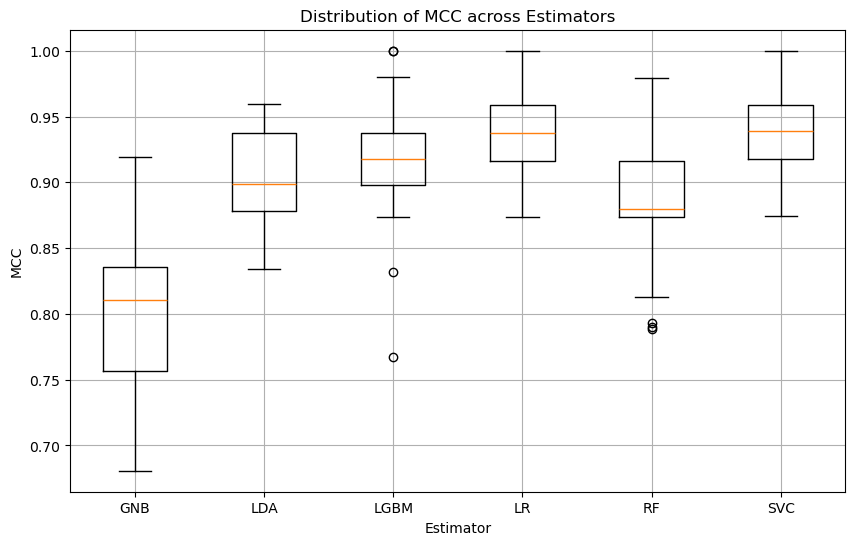

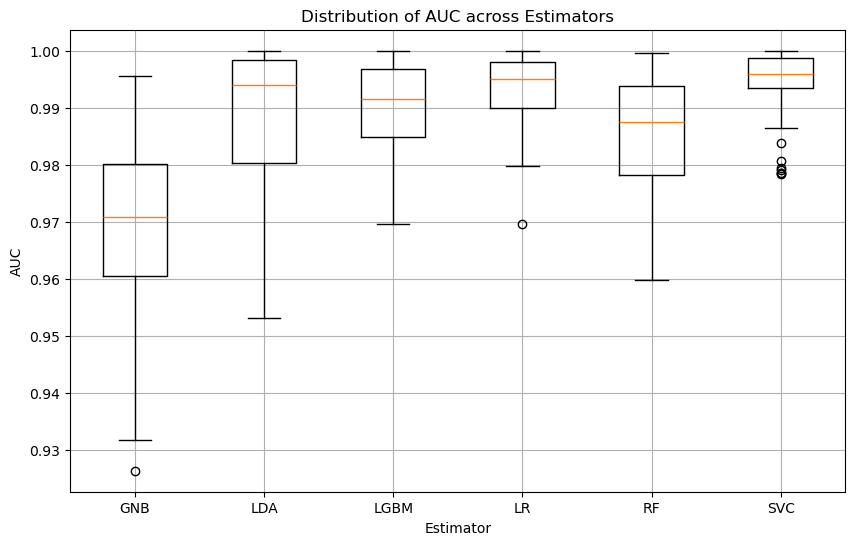

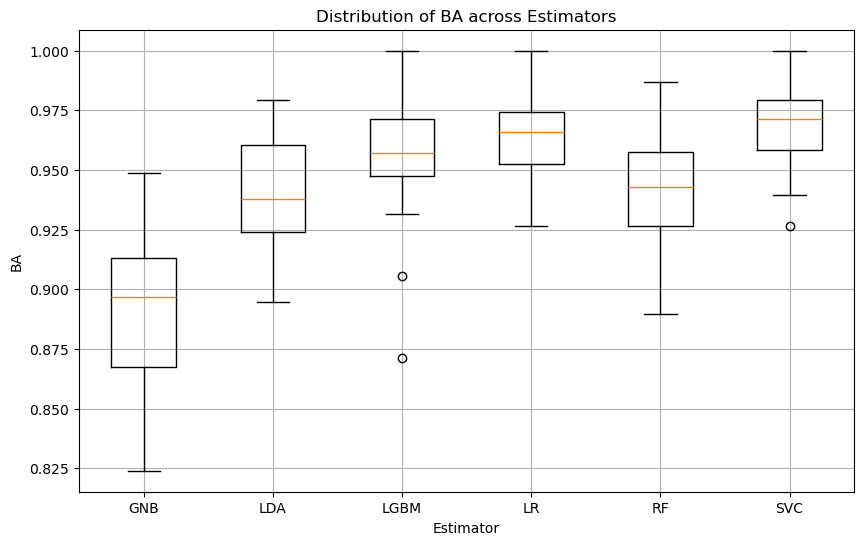

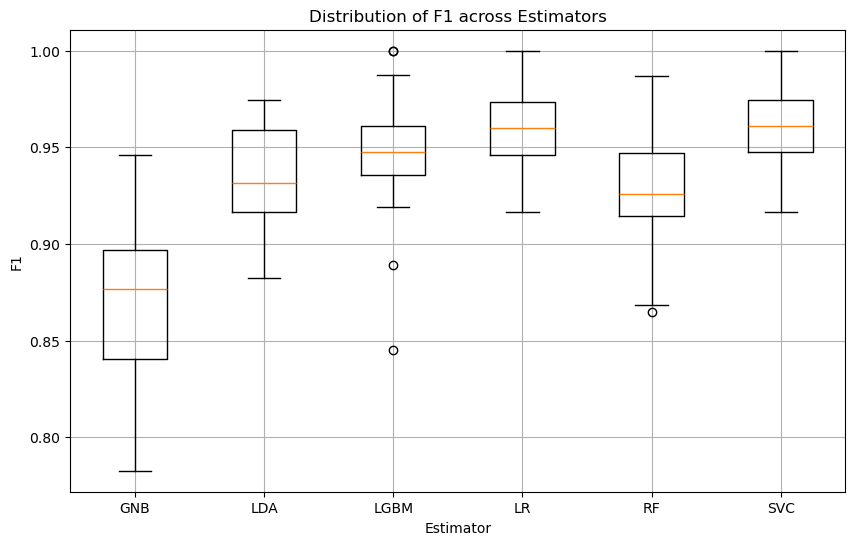

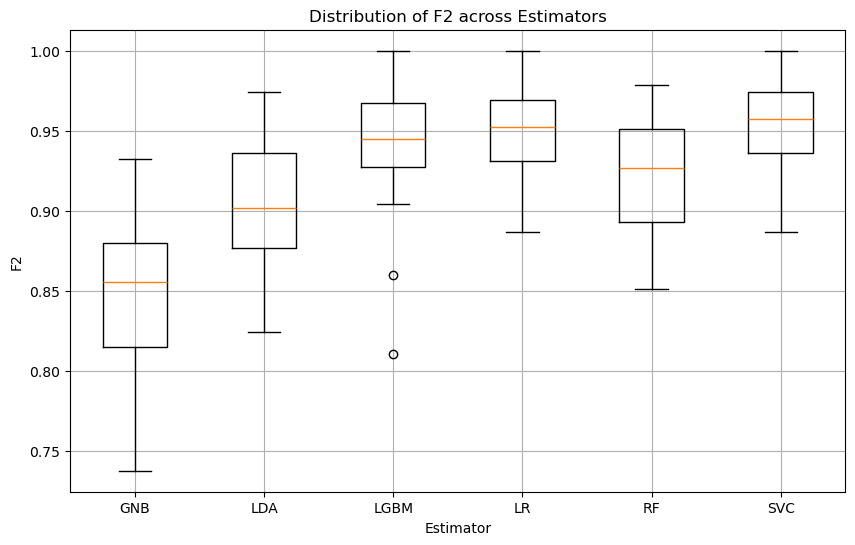

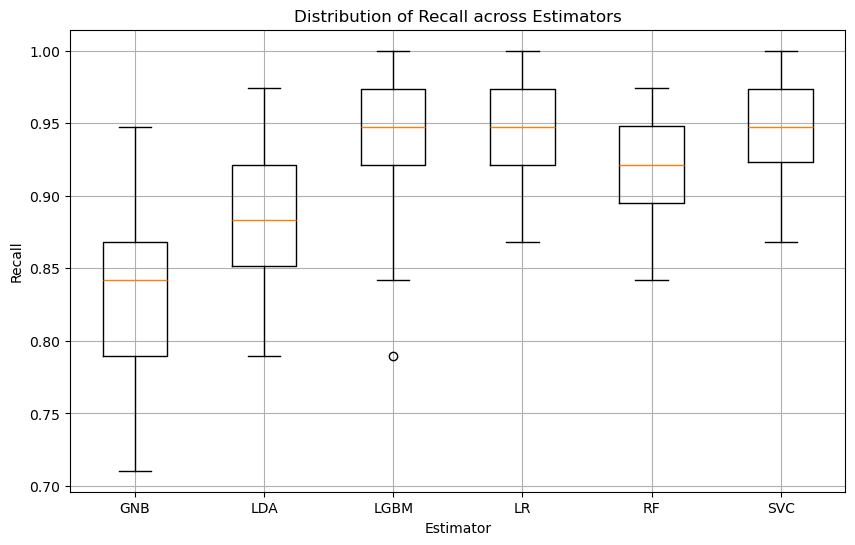

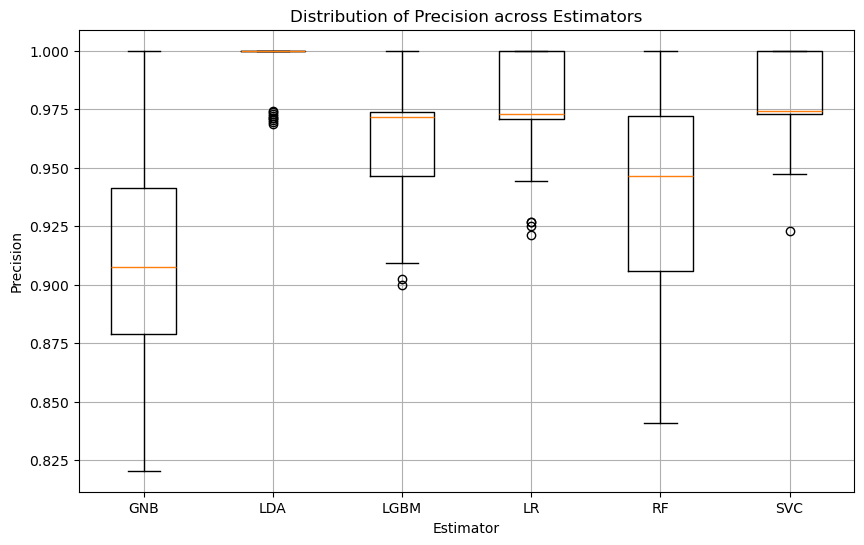

In [8]:
for metric_name in RepeatedNestedCV.METRICS:
    # Group scores by estimators
    grouped = df_results.groupby('estimator')[metric_name].apply(list)

    # Create boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(grouped.values, tick_labels=grouped.index)

    plt.title(f'Distribution of {metric_name} across Estimators')
    plt.xlabel('Estimator')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

### Median Performance Metrics

In [9]:
median_df = df_results.drop(columns=["repetition", "outer_fold"]).groupby("estimator").median()
median_df

,MCC,AUC,BA,F1,F2,Recall,Precision
estimator,,,,,,,
GNB,0.810617,0.970831,0.896682,0.876712,0.855615,0.842105,0.907670
LDA,0.898613,0.993911,0.937727,0.931507,0.901914,0.883266,1.000000
LGBM,0.917468,0.991587,0.957066,0.947368,0.944888,0.947368,0.971825
LR,0.937312,0.995066,0.965872,0.960000,0.952381,0.947368,0.972973
RF,0.879843,0.987480,0.943012,0.925915,0.926880,0.921053,0.946657
SVC,0.938810,0.995951,0.971337,0.961039,0.957447,0.947368,0.974359


### Bootstrap Confidence Intervals

In [10]:
from scipy.stats import bootstrap

def bootstrap_median_ci(data, confidence_level=0.95, n_resamples=10000, random_state=42):
    """
    Compute the confidence interval for the median using bootstrap resampling.

    Args:
        data (array-like): Input data values.
        confidence_level (float): Confidence level for the interval (default 95%).
        n_resamples (int): Number of bootstrap samples (default 10000).
        random_state (int): Random seed for reproducibility.

    Returns:
        (float, float): Lower and upper bounds of the confidence interval.
    """
    data = np.array(data)
    res = bootstrap((data,), np.median, confidence_level=confidence_level,
                    n_resamples=n_resamples, random_state=random_state, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

In [11]:
ci_summary = {}

for estimator in ['LR', 'SVC', 'LGBM']:
    ci_summary[estimator] = {}
    
    for metric in RepeatedNestedCV.METRICS:
        metric_scores = df_results[df_results['estimator'] == estimator][metric].dropna().values

        ci_low, ci_high = bootstrap_median_ci(metric_scores)

        # Store formatted CI string
        ci_summary[estimator][metric] = f"{ci_low:.4f}–{ci_high:.4f}"

# Create dataFrame
ci_summary_df = pd.DataFrame(ci_summary)

# Sort metrics alphabetically
ci_summary_df = ci_summary_df.sort_index()

# 95% Confidence Intervals for Median Metrics Across Estimators
ci_summary_df

,LR,SVC,LGBM
AUC,0.9932–0.9965,0.9935–0.9968,0.9880–0.9943
BA,0.9592–0.9734,0.9663–0.9811,0.9531–0.9614
F1,0.9580–0.9726,0.9484–0.9621,0.9454–0.9488
F2,0.9462–0.9591,0.9438–0.9669,0.9374–0.9589
MCC,0.9350–0.9570,0.9192–0.9403,0.9166–0.9189
Precision,0.9591–0.9737,0.9487–0.9754,0.9711–0.9949
Recall,0.9460–0.9474,0.9211–0.9474,0.9460–0.9737


# Final Model

In [10]:
WINNER_ALGORITHM = "LR" # Logistic Regression

tuner = ModelTuner(
    X=X,
    y=y,
    estimator=estimators[WINNER_ALGORITHM],
    param_space=param_spaces[WINNER_ALGORITHM]
)

best_params = tuner.tune()

final_model = tuner.fit(best_params)

tuner.save(final_model, path='./models/final_model.pkl')

[I 2025-05-09 12:47:26,372] A new study created in memory with name: no-name-793ec30e-3e3a-409e-a29e-444a5ff07050
[I 2025-05-09 12:47:26,424] Trial 0 finished with value: 0.8963628766749455 and parameters: {'C': 0.017670169402947963, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8963628766749455.
[I 2025-05-09 12:47:26,547] Trial 1 finished with value: 0.95975422471625 and parameters: {'C': 2.4658329458549115, 'l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.95975422471625.
[I 2025-05-09 12:47:26,567] Trial 2 finished with value: 0.6950999985596173 and parameters: {'C': 0.0008632008168602552, 'l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.95975422471625.
[I 2025-05-09 12:47:26,585] Trial 3 finished with value: 0.0 and parameters: {'C': 0.00022310108018679258, 'l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.95975422471625.
[I 2025-05-09 12:47:26,639] Trial 4 finished with value: 0.9591729609520565 and parameters: {'C': 0.404

In [11]:
print(best_params)  # Display the best hyperparameters found

{'C': 0.6064586157756967, 'l1_ratio': 0.2533401144197752}
